# Yelp grossometer

Goal: NLP on Austin restaurant reviews to predict cleanliness scores, as determined by health inspection ratings.

Data sources:
   - 2021 Yelp academic dataset
   - Yelp.com web scraping (or API)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import time
# yelp api stuff
from yelpapi import YelpAPI
# web scraping
import requests
from bs4 import BeautifulSoup
# for inspection dates
# import datetime
import pickle as pkl

In [2]:
# map stuff
import folium
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [3]:
%matplotlib inline

In [4]:
main_directory = r'C:\Users\ASUS\Desktop\ML-data science\DataIncubator\yelp-cleaners' + '\\'
data_directory = main_directory + 'data' + '\\'
# raw data
inspection_data_directory = data_directory + r'Inspection data\Austin' + '\\'
yelp_data_directory = main_directory + r'\data\yelp data\austin dataset' + '\\'
# files I generate here
processed_data_directory = main_directory + r'data\processed data' + '\\'

# old stuff
map_path =  main_directory + r'data\states_21basic\states.shp'

In [5]:
# get yelp api key stored in txt file
f = open(data_directory + 'yelp_api_key.txt','r')
api_key = f.read()
f.close()

# data pre-processing

TODO:
1. Get business data
    - Business information from Yelp dataset
    - scrape yelp pages for health inspection scores
2. Get review data
    - Reviews from Yelp dataset (large, need to figure out how to import)

# Get business data

Steps:
1. Grab business information from Yelp dataset
2. Get health inspection scores from city of Austin
3. Match health inspection scores to Yelp businesses

## Extract Austin dataset from 2021 yelp academic dataset

In [6]:
path = yelp_data_directory + 'yelp_academic_dataset_business.json'
df_b = pd.read_json(path, lines=True)

In [7]:
cities = df_b.city.value_counts()[:100]
print(cities.to_string())

Austin               22416
Portland             18203
Vancouver            13330
Atlanta              12612
Orlando              10637
Boston                8263
Columbus              6634
Boulder               2542
Cambridge             2433
Beaverton             2252
Richmond              1791
Burnaby               1725
Kissimmee             1713
Decatur               1411
Winter Park           1288
Somerville            1265
Quincy                1093
Brookline              986
North Vancouver        926
Tigard                 916
Waltham                883
Newton                 823
Smyrna                 820
Altamonte Springs      783
Lake Oswego            761
Dublin                 734
Salem                  721
Sanford                672
Natick                 669
Medford                668
Coquitlam              652
Woburn                 618
Watertown              607
Peabody                602
Burlington             595
Oviedo                 584
Braintree              577
W

In [8]:
austin_businesses = df_b[(df_b.city == 'Austin') & (~df_b.categories.isna())]
austin_restaurants = austin_businesses[austin_businesses.categories.str.contains('Restaurants|Food')].reset_index(drop=True)
austin_restaurants[austin_restaurants.name.str.contains('Hunan')]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
199,EhXO9tfwWD9-xHy1o-S8wg,Hunan Bistro,"10700 Anderson Mill Rd, Ste 105",Austin,TX,78750,30.447545,-97.810281,3.5,82,1,"{'HasTV': 'True', 'Caters': 'True', 'Restauran...","Chinese, Desserts, Food, Restaurants, Asian Fu...","{'Monday': '16:30-21:0', 'Wednesday': '16:30-2..."
2306,kXtG9iZvvIHA_DOKsOc7Fw,Hunan Riverplace,10601 Ranch Rd 2222,Austin,TX,78730,30.392875,-97.844767,3.5,210,1,"{'OutdoorSeating': 'True', 'Alcohol': 'u'none'...","Korean, Restaurants, Chinese","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
2383,g-NDCVx4r4vXfjtTKHMccQ,Hunan Lion,"4006 S Lamar Blvd, Ste 1000",Austin,TX,78704,30.237244,-97.793764,3.5,311,1,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Chinese, Restaurants, Noodles, Asian Fusion","{'Monday': '11:0-22:30', 'Tuesday': '11:0-22:3..."
2754,cwLy575Ou2_N8duSWZbkqw,Hunan Chinese Restaurant,1940 W William Cannon Dr,Austin,TX,78745,30.203218,-97.805739,3.0,47,0,"{'RestaurantsPriceRange2': '1', 'RestaurantsDe...","Chinese, Restaurants","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3..."
3447,RquW4GAxygN6Xn9CIvfwwQ,Hunan Cafe,"1779 Wells Branch Pkwy, Ste 102",Austin,TX,78728,30.435151,-97.674534,4.5,19,0,"{'BusinessParking': '{'garage': False, 'street...","Food, Restaurants, Cafes, Chinese","{'Monday': '16:30-21:30', 'Tuesday': '16:30-21..."
3503,UiM8n-m4D9D9I9P836RILg,Lotus Hunan,"3201 Bee Cave Rd, Ste 109",Austin,TX,78746,30.273024,-97.799406,3.5,171,1,"{'Alcohol': 'u'beer_and_wine'', 'RestaurantsTa...","Seafood, Chinese, Restaurants, Soup","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
5968,T2z5p65IvHZzXjzYHUUlnQ,Hunan Chinese Restaurant,9306 N Lamar Blvd,Austin,TX,78753,30.362152,-97.698624,3.5,75,0,"{'BusinessAcceptsCreditCards': 'True', 'HasTV'...","Chinese, Restaurants",None
6044,l95p5TQT35u6rsmgRo98Ag,Hunan Spicy,"11005 Burnet, Ste 100",Austin,TX,78758,30.394372,-97.720157,3.5,20,0,"{'Ambience': '{'touristy': False, 'hipster': F...","Chinese, Restaurants",None


In [9]:
# just checking: no restaurant appears twice
len(austin_restaurants) == len(austin_restaurants.business_id.unique())

True

In [10]:
# this converts postal_code from int to float, and mangles the attributes and hours columns
austin_restaurants.to_csv(processed_data_directory + 'austin_restaurants.csv', index=False)

In [11]:
austin_rest = pd.read_csv(processed_data_directory + 'austin_restaurants.csv')

In [12]:
austin_rest

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Xw8tuI30T-xihpzwBV-zJg,El Pollo Rey,1725 E Riverside Dr,Austin,TX,78741.0,30.243493,-97.730141,5.0,11,0,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Food Trucks, Restaurants, Specialty Food, Food...",NaN
1,NRPemqVb4qpWFF0Avq_6OQ,Eurasia Sushi Bar & Seafood,"7101 W Hwy 71, Ste C-13",Austin,TX,78735.0,30.234533,-97.877262,4.5,395,1,"{'Ambience': ""{'touristy': False, 'hipster': F...","Bars, Nightlife, Cocktail Bars, Seafood, Resta...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ..."
2,bRsDZ44CD3uhGnRY3NeQhQ,Wendy's,6247 Mcneil Drive,Austin,TX,78729.0,30.441875,-97.746581,2.0,46,1,"{'RestaurantsPriceRange2': '1', 'OutdoorSeatin...","Fast Food, Restaurants, Burgers","{'Monday': '6:30-1:0', 'Tuesday': '6:30-1:0', ..."
3,z-0oY7VxQMQw3JHvdPejrA,Olmecas Mexican Restaurant,2121 E Oltorf St,Austin,TX,78741.0,30.230016,-97.732639,3.0,21,0,"{'Ambience': ""{'romantic': False, 'intimate': ...","Coffee & Tea, Tex-Mex, Restaurants, Mexican, Food","{'Monday': '7:0-23:30', 'Tuesday': '7:0-23:30'..."
4,gjMCRTs0IZbw9bZLG837Bg,CaveMan Cuisine,NaN,Austin,TX,78704.0,30.245673,-97.768836,1.5,6,0,"{'RestaurantsPriceRange2': '3', 'BusinessAccep...","Food, Food Delivery Services",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6339,bsltkBbgcAUTaW3awpJpmg,Trai Mai Thai,603 W Live Oak,Austin,TX,78704.0,30.244371,-97.758238,3.0,6,0,"{'NoiseLevel': ""u'quiet'"", 'RestaurantsTakeOut...","Thai, Restaurants, Vegetarian","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'..."
6340,dO-GVMx-WaxDZ4TN6gBvVg,Target,5621 N I H 35,Austin,TX,78723.0,30.316057,-97.706760,3.0,70,1,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Fashion, Department Stores, Grocery, Electroni...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-22:0', '..."
6341,io_UQS_WwonlCPCfKy3Hdw,Super Bowl,"719 W William Cannon Dr, Ste 103",Austin,TX,78745.0,30.196750,-97.788452,3.5,214,1,"{'RestaurantsGoodForGroups': 'True', 'Alcohol'...","Restaurants, Chinese","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
6342,EaBDXdIQ_TeeUhn1Twnjvg,Shanghai Noodle House,"10300 Anderson Mill Rd, Ste A",Austin,TX,78750.0,30.447543,-97.804432,3.5,83,1,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Restaurants, Bubble Tea, Coffee & Tea, Food, N...","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."


In [14]:
austin_restaurants.address[0]

'1725 E Riverside Dr'

In [15]:
austin_rest.address[0]

'1725 E Riverside Dr'

(array([   7.,  104.,  275.,  403.,  818., 1332., 1688., 1273.,  444.]),
 array([1.        , 1.44444444, 1.88888889, 2.33333333, 2.77777778,
        3.22222222, 3.66666667, 4.11111111, 4.55555556, 5.        ]),
 <BarContainer object of 9 artists>)

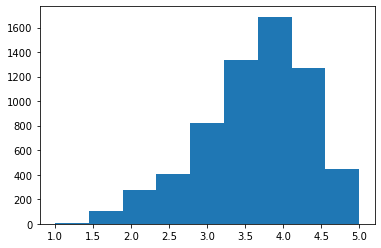

In [16]:
plt.hist(austin_restaurants.stars,bins=9)

<AxesSubplot:>

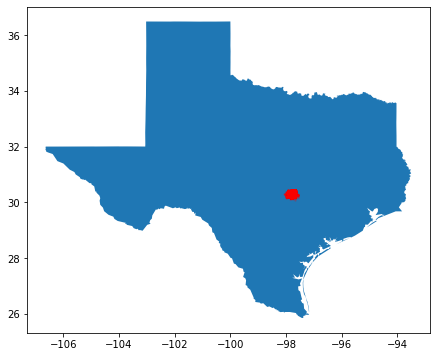

In [17]:
latlong = austin_restaurants[['latitude','longitude']]
geometry = [Point(xy) for xy in zip(latlong['longitude'], latlong['latitude'])]
gdf = GeoDataFrame(latlong, geometry=geometry)   
usa = gpd.read_file(map_path)
usa = usa[~usa['STATE_NAME'].isin(['Hawaii','Alaska'])] # exclude HI & AK
texas = usa[usa['STATE_NAME'] == 'Texas']
gdf.plot(ax=texas.plot(figsize=(10, 6)), marker='o', color='red', markersize=2, alpha=0.2)

## Health inspection data

Yelp has this data on some of their business pages (rolled out early 2022). I tried three ways to get it:
1. Query Yelp Fusion API. No health information through their API yet, unfortunately.
2. Scrape Yelp site directly. This got me IP banned within 100 scraped pages, as Yelp does not like web crawlers.
3. Ditch Yelp and get the data from the city of Austin directly, available at: https://data.austintexas.gov/Health-and-Community-Services/Food-Establishment-Inspection-Scores/ecmv-9xxi.
    - Need to match businesses with Yelp business IDs, which can be done with Yelp API queries (business name and address).

### import/clean inspection data from city of Austin

In [19]:
# not that big
df = pd.read_csv(inspection_data_directory + 'Food_Establishment_Inspection_Scores.csv',
                delimiter = ',', on_bad_lines='skip')

# clean up address data, extracting lat/long
# formatted as Address \n city, state, zip \n (lat, long)
df.Address = df.Address.apply(lambda x: x.split('\n'))
df['latitude'] = df.Address.apply(lambda x: eval(x[2])[0] if len(x) == 3 else None)
df['longitude'] = df.Address.apply(lambda x: eval(x[2])[1] if len(x) == 3 else None)
df['Address Line 2'] = df.Address.str[1]
df.Address = df.Address.str[0]
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])

In [20]:
df

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description,latitude,longitude,Address Line 2
0,LW - Crown Donut,78734.0,2019-12-06,97,325 S FM 620 RD,10545024,Routine Inspection,NaN,NaN,"LAKEWAY, TX 78734"
1,Riverside Grocery,78701.0,2022-03-03,99,30 N IH,2803648,Routine Inspection,NaN,NaN,"AUSTIN, TX 78701"
2,Circle K #2741303,78748.0,2021-06-25,91,8628 MANCHACA RD,2803589,Routine Inspection,NaN,NaN,"AUSTIN, TX 78748"
3,Stop 71,78735.0,2020-03-03,78,8314 W SH,2803909,Routine Inspection,NaN,NaN,"AUSTIN, TX 78735"
4,Angel's Ice House,78669.0,2021-11-16,94,21815 W SH,2802178,Routine Inspection,NaN,NaN,"SPICEWOOD, TX 78669"
...,...,...,...,...,...,...,...,...,...,...
25779,"Commodore Perry Estate, The",78751.0,2021-11-18,84,4114 RED RIVER ST,12392635,Routine Inspection,30.300755,-97.721903,"AUSTIN, TX 78751"
25780,El Mercado North,78757.0,2021-07-27,89,7414 BURNET RD,2800466,Routine Inspection,30.350003,-97.734632,"AUSTIN, TX 78757"
25781,Wendy's #W129/11274,78759.0,2019-12-31,82,10701 RESEARCH BLVD,11115872,Routine Inspection,30.398568,-97.745647,"AUSTIN, TX 78759"
25782,Slapbox Pizzicheria,78717.0,2021-10-18,80,9900 W PARMER LN,12393453,Routine Inspection,30.486294,-97.770553,"AUSTIN, TX 78717"


In [21]:
# number of inspected facilities
len(df['Facility ID'].unique())

6680

In [22]:
# get latest score
latest_scores = df.sort_values('Inspection Date').groupby(['Facility ID']).tail(1).reset_index(drop=True)
latest_scores

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description,latitude,longitude,Address Line 2
0,Blenders and Bowls,78758.0,2019-04-29,84,11010 DOMAIN DR,12074384,Routine Inspection,30.396729,-97.726474,"AUSTIN, TX 78758"
1,Spansion Cafeteria,78741.0,2019-05-01,100,5204 E BEN WHITE BLVD,10398805,Routine Inspection,30.214204,-97.724823,"AUSTIN, TX 78741"
2,Planet,78702.0,2019-05-02,97,2921 E 17TH ST,12162918,Routine Inspection,30.279350,-97.710333,"AUSTIN, TX 78702"
3,OOB - LW - Holiday Inn Express,78734.0,2019-05-03,99,15707 OAK GROVE BLVD,10867994,Routine Inspection,30.381157,-97.946063,"LAKEWAY, TX 78734"
4,LW-Acai Hut,78734.0,2019-05-03,99,2125 LOHMANS CROSSING RD,12149504,Routine Inspection,30.342143,-97.970843,"LAKEWAY, TX 78734"
...,...,...,...,...,...,...,...,...,...,...
6675,"WL - MOD Super Fast Pizza, LLC",78746.0,2022-04-05,89,701 S CAPITAL OF TEXAS HWY,11313184,Routine Inspection,30.292189,-97.828184,"WEST LAKE HILLS, TX 78746"
6676,Comedor,78701.0,2022-04-05,87,501 COLORADO ST,12117759,Routine Inspection,30.267884,-97.744331,"AUSTIN, TX 78701"
6677,Tokyo Garden Catering,78731.0,2022-04-05,93,7025 VILLAGE CENTER DR,2802634,Routine Inspection,30.352585,-97.756179,"AUSTIN, TX 78731"
6678,"Commodore Perry Estate, The",78751.0,2022-04-05,91,4114 RED RIVER ST,12392635,Routine Inspection,30.300755,-97.721903,"AUSTIN, TX 78751"


In [23]:
# get average score
mean_scores = df.groupby(['Facility ID','Restaurant Name','Address']).mean()
print(len(mean_scores))
print(len(df['Facility ID'].unique()))
mean_scores

6680
6680


,,,Zip Code,Score,latitude,longitude
Facility ID,Restaurant Name,Address,,,,
2800004,Threadgill's,6416 N LAMAR BLVD,78752.0,98.666667,30.332501,-97.722202
2800006,Webb Middle School,601 E ST JOHNS AVE,78752.0,97.333333,30.333921,-97.706498
2800007,Whataburger #132,9516 N LAMAR BLVD,78753.0,97.500000,30.365158,-97.695835
2800008,Wooldridge Elementary,1412 NORSEMAN TER,78758.0,99.333333,30.364408,-97.710271
2800009,Wooten Elementary,1406 DALE DR,78757.0,96.200000,30.353261,-97.719876
...,...,...,...,...,...,...
12395919,7-Eleven Convenience Store # 41166A,17000 SWEETWATER VILLAGE DR,78738.0,98.000000,NaN,NaN
12396012,McDonald's #14128,1024 E ANDERSON LN,78753.0,100.000000,30.336471,-97.693911
12396015,McDonald's #424,5355 N IH,78723.0,87.000000,NaN,NaN


In [24]:
# export cleaned dataframe
df.to_csv(processed_data_directory + 'austin_inspections.csv', index=False)

### Query Yelp API for inspected restaurant name/address

Need to send ~7000 queries, but Yelp API only allows 5000/day so I ran it over two days.

In [348]:
yelp_api = YelpAPI(api_key, timeout_s=3.0)
yelp_api_responses_file = processed_data_directory + 'yelp_api_responses.pkl'

In [349]:
search_me = latest_scores

In [350]:
# try one
test = search_me.loc[196]
print(test)
response = yelp_api.business_match_query(name=test['Restaurant Name'],
                                             address1=test['Address'],
                                             city='Austin',
                                             state='TX',
                                             country='US')
response

Restaurant Name        Flea Market # L (Snow Cones)
Zip Code                                    78754.0
Inspection Date                 2019-09-07 00:00:00
Score                                            93
Address                           9500 E US 290 HWY
Facility ID                                 2802136
Process Description              Routine Inspection
latitude                                  30.330694
longitude                                -97.630914
Address Line 2                     AUSTIN, TX 78754
Name: 196, dtype: object


{'businesses': [{'id': 'TMh9t4DSyWyNouN7SNVpPg',
   'alias': 'austin-country-flea-market-austin',
   'name': 'Austin Country Flea Market',
   'coordinates': {'latitude': 30.3326680562269,
    'longitude': -97.6308107674725},
   'location': {'address1': '9500 Hwy 290 E',
    'address2': '',
    'address3': '',
    'city': 'Austin',
    'zip_code': '78724',
    'country': 'US',
    'state': 'TX',
    'display_address': ['9500 Hwy 290 E', 'Austin, TX 78724']},
   'phone': '+15129284711',
   'display_phone': '(512) 928-4711'}]}

In [357]:
len(search_me)

6680

In [358]:
# for loop through entire thing
# only 5000 queries/day
all_responses = {}
for i in range(5000,len(search_me),1):
    time.sleep(0.05)
    test = search_me.loc[i]
    response = yelp_api.business_match_query(name=test['Restaurant Name'],
                                             address1=test['Address'],
                                             city='Austin',
                                             state='TX',
                                             country='US')
    # save the full response, no cleaning
    all_responses[test['Facility ID']] = response

In [359]:
# how many non-empty entries exist
sum([i['businesses'] != [] for i in all_responses.values()])

1163

In [360]:
# # append new responses to saved dictionary
# pkl_file = open(yelp_api_responses_file, 'rb')
# out = pkl.load(pkl_file)
# out.update(all_responses)
# pkl_file.close()

# output = open(yelp_api_responses_file, 'wb')
# pkl.dump(out, output)
# output.close()

In [361]:
len(out)

6680

In [362]:
# how many non-empty entries exist
sum([i['businesses'] != [] for i in out.values()])

4632

In [363]:
# number left to query
len(search_me)-len(out)

0

## combine Yelp restaurant data with health inspection data

In [8]:
# import yelp api responses (dict of json) and convert to dataframe
yelp_api_responses_file = processed_data_directory + 'yelp_api_responses.pkl'
pkl_file = open(yelp_api_responses_file, 'rb')
out = pkl.load(pkl_file)
pkl_file.close()

id_df = pd.DataFrame({
    'Facility ID': out.keys(),
    'Yelp ID': out.values()
})
id_df['Yelp ID'] = id_df['Yelp ID'].apply(lambda x: x['businesses'])

In [246]:
id_df['Yelp ID'].str.len().value_counts()

1    4630
0    2048
2       2
Name: Yelp ID, dtype: int64

In [235]:

# clean it up
id_df = id_df[id_df['Yelp ID'].str.len() != 0] # remove businesses not on yelp
# note: there's only two business searches with >1 result, and the first result is the correct one for both (checked manually)
id_df['Yelp ID'] = id_df['Yelp ID'].apply(lambda x: x[0]['id']) # take first result of the rest

In [36]:
id_df.to_csv(processed_data_directory + 'business_id_df.csv', index=False)

In [239]:
id_df['Yelp ID'].value_counts()

zohVnwZ3NeRLcUQiYb-EDg    25
kaB2yCo4nV5vfsOwoHus7A    20
ObL06JtR47jUwgj07rEBGQ    13
TMh9t4DSyWyNouN7SNVpPg    11
R1rL_RD4xyVwcWRIA8YB2w    10
                          ..
ZJFIDLUiZ2Vs0NTj0pGVfg     1
vO_n4PqXXs6SqgKFv1C53A     1
0CA07QXBNQbpL5g5FWPAMQ     1
C42T3RhTB44bx0wqA9zPdg     1
TSKMu1M0HAFoPvCZuJxx1w     1
Name: Yelp ID, Length: 4213, dtype: int64

### manually check entries with > 1 result

Turns out all entries with >1 result should use the first result. Kudos to Yelp's search.

In [367]:
ambiguous_entries = id_df[id_df['Yelp ID'].apply(lambda x: len(x)==2)]['Facility ID'].index.tolist()

In [368]:
# this restaurant has two entries, choose the first one with more reviews
id_df.loc[ambiguous_entries[0]]['Yelp ID']

[{'id': 'YJ3lsGCgOJ07FYqUQyqxNg',
  'alias': 'tiny-pies-austin-8',
  'name': 'Tiny Pies',
  'coordinates': {'latitude': 30.255177953580507,
   'longitude': -97.76223801361445},
  'location': {'address1': '1100 S Lamar Blvd',
   'address2': 'Ste 1116',
   'address3': '',
   'city': 'Austin',
   'zip_code': '78704',
   'country': 'US',
   'state': 'TX',
   'display_address': ['1100 S Lamar Blvd', 'Ste 1116', 'Austin, TX 78704']},
  'phone': '+15124609697',
  'display_phone': '(512) 460-9697'},
 {'id': 'wEynpW1i7ExOvKSVzYvcbQ',
  'alias': 'tiny-pies-austin-9',
  'name': 'Tiny Pies',
  'coordinates': {'latitude': 30.25576, 'longitude': -97.76252},
  'location': {'address1': '1100 S Lamar Blvd',
   'address2': None,
   'address3': '',
   'city': 'Austin',
   'zip_code': '78704',
   'country': 'US',
   'state': 'TX',
   'display_address': ['1100 S Lamar Blvd', 'Austin, TX 78704']},
  'phone': '+15124609697',
  'display_phone': '(512) 460-9697'}]

In [369]:
search_me

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description,latitude,longitude,Address Line 2
0,Blenders and Bowls,78758.0,2019-04-29,84,11010 DOMAIN DR,12074384,Routine Inspection,30.396729,-97.726474,"AUSTIN, TX 78758"
1,Spansion Cafeteria,78741.0,2019-05-01,100,5204 E BEN WHITE BLVD,10398805,Routine Inspection,30.214204,-97.724823,"AUSTIN, TX 78741"
2,Planet,78702.0,2019-05-02,97,2921 E 17TH ST,12162918,Routine Inspection,30.279350,-97.710333,"AUSTIN, TX 78702"
3,OOB - LW - Holiday Inn Express,78734.0,2019-05-03,99,15707 OAK GROVE BLVD,10867994,Routine Inspection,30.381157,-97.946063,"LAKEWAY, TX 78734"
4,LW-Acai Hut,78734.0,2019-05-03,99,2125 LOHMANS CROSSING RD,12149504,Routine Inspection,30.342143,-97.970843,"LAKEWAY, TX 78734"
...,...,...,...,...,...,...,...,...,...,...
6675,"WL - MOD Super Fast Pizza, LLC",78746.0,2022-04-05,89,701 S CAPITAL OF TEXAS HWY,11313184,Routine Inspection,30.292189,-97.828184,"WEST LAKE HILLS, TX 78746"
6676,Comedor,78701.0,2022-04-05,87,501 COLORADO ST,12117759,Routine Inspection,30.267884,-97.744331,"AUSTIN, TX 78701"
6677,Tokyo Garden Catering,78731.0,2022-04-05,93,7025 VILLAGE CENTER DR,2802634,Routine Inspection,30.352585,-97.756179,"AUSTIN, TX 78731"
6678,"Commodore Perry Estate, The",78751.0,2022-04-05,91,4114 RED RIVER ST,12392635,Routine Inspection,30.300755,-97.721903,"AUSTIN, TX 78751"


In [370]:
search_me[search_me['Facility ID'] == id_df.loc[ambiguous_entries[1]]['Facility ID']]

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description,latitude,longitude,Address Line 2
3487,Teapioca Arboretum,78759.0,2021-12-01,90,10000 RESEARCH BLVD,11793105,Routine Inspection,30.392352,-97.746845,"AUSTIN, TX 78759"


In [371]:
# this one has a weird name in the inspection database, but it's clearly the first entry
id_df.loc[ambiguous_entries[1]]['Yelp ID']

[{'id': 'hrDUqL02tA-6lnnopguEyg',
  'alias': 'teapioca-lounge-austin-5',
  'name': 'Teapioca Lounge',
  'coordinates': {'latitude': 30.391071, 'longitude': -97.7487887},
  'location': {'address1': '10000 Research Blvd',
   'address2': 'Ste 137',
   'address3': '',
   'city': 'Austin',
   'zip_code': '78759',
   'country': 'US',
   'state': 'TX',
   'display_address': ['10000 Research Blvd', 'Ste 137', 'Austin, TX 78759']},
  'phone': '+15128383656',
  'display_phone': '(512) 838-3656'},
 {'id': 'CRsIi2lNdBytSE9JEqzRFg',
  'alias': 'the-arboretum-austin-2',
  'name': 'The Arboretum',
  'coordinates': {'latitude': 30.392271, 'longitude': -97.748204},
  'location': {'address1': '10000 Research Blvd',
   'address2': None,
   'address3': '',
   'city': 'Austin',
   'zip_code': '78759',
   'country': 'US',
   'state': 'TX',
   'display_address': ['10000 Research Blvd', 'Austin, TX 78759']},
  'phone': '+15123384755',
  'display_phone': '(512) 338-4755'}]

### combine

We need to combine:
1. austin_rest: yelp data
2. id_df: yelp and inspection business IDs
3. austin_inspections: health inspection data

Austin_inspections has a lot of different inspections for each restaurant. Let's keep all of it, since we can use the latest score based on the date of the review.

In [444]:
austin_rest = pd.read_csv(processed_data_directory + 'austin_restaurants.csv')
austin_inspections = pd.read_csv(processed_data_directory + 'austin_inspections.csv')
id_df = pd.read_csv(processed_data_directory + 'business_id_df.csv')

In [445]:
# tack on inspection business IDs ('Facility ID') to yelp data
business_df = austin_rest.merge(right=id_df, how='inner', left_on='business_id', right_on='Yelp ID')
business_df = business_df.drop('Yelp ID',axis=1) # merge duplicates the column, so drop one of them

# merge with inspection data
business_df = business_df.merge(right=austin_inspections, how='inner', on='Facility ID')

# set column type for comparison
business_df['Address'] = business_df['Address'].astype('str')
business_df['address'] = business_df['address'].astype('str')

### check yelp API queries

In [446]:
# check how well we did by comparing the similarity of restaurant name and address
from difflib import SequenceMatcher
def similar(a, b): return SequenceMatcher(None, a, b).ratio()

similarity_threshold = 0.6 # sort of arbitrary
dissimilar_businesses = business_df[business_df.apply(lambda x: similar(x['address'].lower(), x['Address'].lower())<similarity_threshold, axis=1)]
dissimilar_businesses = dissimilar_businesses[dissimilar_businesses.apply(lambda x: similar(x['name'].lower(), x['Restaurant Name'].lower())<similarity_threshold, axis=1)]
cols = ['name','Restaurant Name','address','Address']
dissimilar_businesses[cols].groupby(cols).tail(1)

,name,Restaurant Name,address,Address
602,Fiesta Mart,Fiesta Mart #25 (Grocery/Meat),3909 N I-35 Srvc Rd,3909 N IH
606,Fiesta Mart,Fiesta Mart #25 (Seafood/Deli),3909 N I-35 Srvc Rd,3909 N IH
613,Fiesta Mart,Fiesta Mart #25 (Bakery/Taqueria),3909 N I-35 Srvc Rd,3909 N IH
4768,Vino Volo,ABIA - Vino Volo High Plains,Austin Airport,3600 PRESIDENTIAL BLVD
5182,East Side Pies,ABIA-East Side Pies (West Food Park),"3600 Presidential Blvd, West Food Court, Austi...",3600 PRESIDENTIAL BLVD
5205,The Pickle House,"OOB Pickle House Restaurant, The","9521 US-290, Ste 100",9521 W US 290 HWY
5328,Alpine Engine,Four Seasons Hotel Austin,nan,98 SAN JACINTO BLVD
6030,Poke Austin,Poke-Poke,"5601 Brodie Ln, Ste 1200A",9911 BRODIE LN
6238,Haymaker,ABIA - Haymaker Sports Bar,"3600 Presidential Blvd, Gate 24, Austin-Bergst...",3600 PRESIDENTIAL BLVD


In [447]:
# there's only one that we actually got wrong: "Alpine Engine"
business_df.drop(business_df.index[business_df['name'].str.contains('Alpine Engine')],axis=0,inplace=True)

### deal with duplicate Facility IDs

Some businesses have multiple Facility IDs in the inspection data that correspond to the same Yelp business_id. We need to collapse it down so that one facility ID corresponds to one business_id.

There are 167 such businesses and 376 facility IDs total. Since this is actually a relatively small number, we can check them manually.

In [448]:
# some businesses have multiple inspection Facility IDs for the same Yelp business_id
multiple_insp_IDs = business_df.groupby(['business_id'])['Facility ID'].nunique()
multiple_insp_IDs = multiple_insp_IDs[multiple_insp_IDs>1].index.tolist()
print(f'# duplicates: {len(multiple_insp_IDs)}')

# this is a small number so we can check manually.
duplicate_facility_IDs = business_df[business_df['business_id'].isin(multiple_insp_IDs)][['business_id','name','address','Restaurant Name','Address','Facility ID','Inspection Date','Score']]
# show only latest scores
duplicate_facility_IDs = duplicate_facility_IDs.sort_values(['business_id','Facility ID','Inspection Date']).groupby(['business_id','Facility ID']).tail(1).reset_index(drop=True)

# look at all multiple inspection data manually
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(duplicate_facility_IDs)

# duplicates: 167


It looks like there are no errors here. All of the restaurant names and addresses seem to match up. There are two reasons for the multiple Facility IDs:
1. Intentional multiple entries for a business: Whole Foods bakery vs. Whole Foods deli. These have the same inspection date.
2. Unintentional separate Facility ID when a new inspection is done. These have different inspection dates.

To fix #1 we average all inspections on the same date for a given business_id. To fix #2, we just consider the business_id to be the unique primary key for each business. Then we can remove the business name and address columns left over from the Inspection dataframe.

In [449]:
# average scores for a business from the same inspection date
averaged_scores = business_df[['business_id','Inspection Date','Score']].groupby(['business_id','Inspection Date'],as_index=False).mean()
# cut down to only the useful columns
cols = ['business_id','name','address','latitude_x','longitude_x','stars','review_count','is_open','attributes','categories']
business_df = business_df[cols].drop_duplicates().merge(averaged_scores,on=['business_id'],how='inner')
business_df = business_df.rename({'latitude_x': 'latitude', 'longitude_x': 'longitude'}, axis=1)

In [460]:
# export
business_df.to_csv(processed_data_directory + 'business_df.csv', index=False)

### simplify inspection data

We can use the inspection score based on the date of the review, but first let's just take the latest inspection score to make things simpler.

In [459]:
latest_inspection = business_df.sort_values(['business_id','Inspection Date']).groupby(['business_id']).tail(1).reset_index(drop=True)

In [461]:
latest_inspection.to_csv(processed_data_directory + 'business_df_latest_inspection.csv', index=False)

### overall metrics

In [465]:
business_df = pd.read_csv(processed_data_directory + 'business_df_latest_inspection.csv')

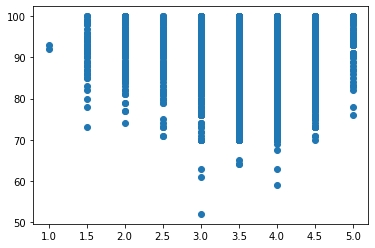

In [466]:
plt.scatter(business_df.stars,business_df.Score)
plt.show()

In [467]:
business_df.groupby('is_open').agg(
    mean_stars=('stars', 'mean'),
    err_stars=('stars', 'sem'),
    mean_Score=('Score', 'mean'),
    err_Score=('Score', 'sem'),
)

,mean_stars,err_stars,mean_Score,err_Score
is_open,,,,
0,3.554622,0.048061,89.941176,0.518686
1,3.628527,0.016591,89.202227,0.155549


<AxesSubplot:title={'center':'Score'}, xlabel='[is_open]'>

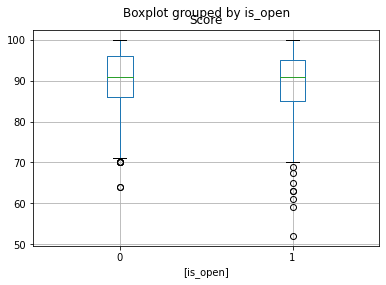

In [468]:
business_df[['Score','is_open']].boxplot(by='is_open')

Text(0.5, 0, 'Average Review (out of 5 stars)')

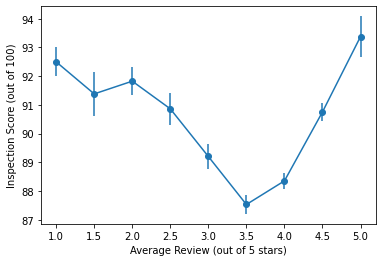

In [469]:
score_by_stars = business_df.groupby('stars').agg(
    mean_Score=('Score', 'mean'),
    err_Score=('Score', 'sem'),
)
plt.errorbar(x=score_by_stars.index,
             y=score_by_stars.mean_Score,
             yerr=score_by_stars.err_Score,
             marker='o')
plt.ylabel('Inspection Score (out of 100)')
plt.xlabel('Average Review (out of 5 stars)')

<AxesSubplot:title={'center':'Score'}, xlabel='[stars]'>

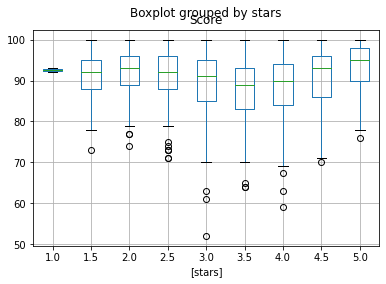

In [470]:
business_df[['stars','Score']].boxplot(by='stars')

# Get review data

There are a lot of reviews within the Yelp academic dataset, so first we should trim it to only reviews on Austin restaurants with inspection scores.

In [485]:
business_df = pd.read_csv(processed_data_directory + 'business_df_latest_inspection.csv')
business_ids = business_df['business_id']

In [486]:
review_filepath = yelp_data_directory + 'yelp_academic_dataset_review.json'
size = 500000
json_reader = pd.read_json(review_filepath, lines=True,
                           dtype={'review_id':str,'user_id':str,
                                  'business_id':str,'stars':int,
                                  'date':str,'text':str,
                                  'useful':int,'funny':int,'cool':int},
                           chunksize=size)

In [487]:
# i=0
chunk_list=[]
for chunk in json_reader:
    # i+=1
    # drop data we don't need
    # chunk = chunk.drop(['review_id','user_id','useful','funny','cool'], axis=1).reset_index(drop=True)
    chunk = chunk.rename(columns={'stars': 'review_stars'})
    # limit to health-inspected austin restaurants
    chunk = chunk[chunk['business_id'].isin(business_ids)]
    # chunk = pd.merge(business_df, chunk, on='business_id', how='inner') # this generates duplicates for some reason???
    chunk_list.append(chunk)
    print(f"{len(chunk)} out of {size} related reviews")
    # if i==5:
    #     break
    # break

45301 out of 500000 related reviews
39863 out of 500000 related reviews
32808 out of 500000 related reviews
34664 out of 500000 related reviews
34956 out of 500000 related reviews
37157 out of 500000 related reviews
33048 out of 500000 related reviews
31656 out of 500000 related reviews
30599 out of 500000 related reviews
30174 out of 500000 related reviews
28740 out of 500000 related reviews
27360 out of 500000 related reviews
30598 out of 500000 related reviews
29903 out of 500000 related reviews
29728 out of 500000 related reviews
33042 out of 500000 related reviews
33161 out of 500000 related reviews
7856 out of 500000 related reviews


In [493]:
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
df.to_csv(processed_data_directory + 'review_df.csv', index=False)

## look at review data

In [503]:
df = pd.read_csv(processed_data_directory + 'review_df.csv')

In [505]:
# check there's no duplicates
len(df) == len(df['review_id'].unique())

True

In [512]:
# make sure we hit every business
len(df.business_id.unique()) == len(business_df.business_id.unique())

True

In [513]:
df

,review_id,user_id,business_id,review_stars,useful,funny,cool,text,date
0,GDgXjXSZCA1iNQWD7OHXfg,1RCRKuHgP3FskGUVnmFdxg,mOnesB4IF9j6-ZmHoOHOig,4,0,0,0,I think their rice dishes are way better than ...,2017-05-26 03:05:46
1,GgWFjRHhelaiUgR2-H6N4g,pRPT3vqhqpU7kHgmKJamvw,-_GnwXmzC3DXsHR9nyaC2g,3,0,0,0,3.5 stars! I got the avocado margarita and it ...,2012-11-06 07:09:57
2,z-6ElnK3yXpn2oNKR7NYtw,OSsqq7CzBdAbF7E6kZHd0g,bZiIIUcpgxh8mpKMDhdqbA,3,0,0,0,My husband and I shared the parmesan truffly f...,2017-10-11 00:25:47
3,nqUJoSkDr_1mqnLtOrWFSA,HLE4PMeOrkQkIR559IkY9A,gvpoFnaCq2J7TBXV7yFIkQ,5,0,0,0,"Perfect spices, nice atmosphere & music, great...",2017-07-28 19:17:54
4,h6o5mduBqDUkKsa4KRIDzw,Nw4GV60oM78Uizh9dUuqNQ,LUCmOKTK5Uh7eU84yJq3mQ,5,0,0,0,Snap is my go-to lunch spot nearly every day! ...,2015-06-08 18:07:06
...,...,...,...,...,...,...,...,...,...
570609,I_8BJ6vZo7mVHi4TzuEK2A,74bzP169TBBFLEnzQsCdHw,dgywJM4JpniwOEDNfrfewg,2,10,0,3,I rec'd my meal as part of a complimentary Yel...,2020-08-09 19:53:40
570610,oabuTmGpHquA4sc4C0DatQ,tsSyIyhRp37fDpN78q3crw,Qmq4gr5Mmo2oIVejag48PA,4,4,1,3,This place serves amazingly tasty gluten free ...,2020-09-13 00:53:03
570611,hKxvxtCjEJAwD_7AcnA_iQ,VEB7udH-qIN_ON1SMyWrPg,zM98ZSIJyuBQabyYornLpw,3,0,0,0,Bartender was friendly and attentive. We came ...,2021-01-10 04:10:45
570612,UWHPbsQzfrmjtDCbq2AeDg,Cx85VtZCOwdzHATPlB6fyQ,Wn8j-1-ity6hdjP4bC_wkw,2,0,0,0,Terrible pho. Literally zero flavor. And the c...,2021-01-17 22:09:10


In [548]:
num_reviews = df.groupby('business_id').size()
num_reviews.name = 'num_reviews_in_dataset'
num_reviews

business_id
-0TbQsmE2p1bhG30rgvK2Q      93
-4bP1UUgpZumIu6DZMaMzw     556
-4cQ12xutjNLW-tPI06_tg      86
-4ofMtrD7pSpZIX5pnDkig    1474
-6obgh8LkS9L0Ww1zHdTNg      17
                          ... 
zlPKCqb9sfkhIW27sAGsIA     104
zo-POOSRX0wiVJlJyvujyA      41
zr40jIjFDIcZ3dzbSK53Ww     114
zubXuwlAEbvZd-MiLOgofQ     175
zvSUJ7J2-GcB-2E0W2ICbw       6
Name: num_reviews_in_dataset, Length: 2506, dtype: int64

In [549]:
num_reviews[num_reviews==max(num_reviews)]

business_id
MGzro82Fi4LYvc86acoONQ    5071
Name: num_reviews_in_dataset, dtype: int64

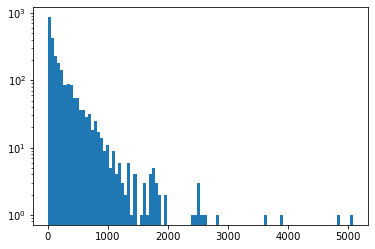

In [550]:
# see # reviews distribution
plt.hist(num_reviews,bins = 100)
plt.yscale('log')

In [551]:
business_df

,business_id,name,address,latitude,longitude,stars,review_count,is_open,attributes,categories,Inspection Date,Score
0,-0TbQsmE2p1bhG30rgvK2Q,RiverCity Market,2209 S Congress Ave,30.240873,-97.752353,4.0,89,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Beer, Wine & Spirits, Grocery, Food, Specialty...",2022-03-02,91.0
1,-4bP1UUgpZumIu6DZMaMzw,Houndstooth Coffee,"4200 N Lamar Blvd, Ste 120",30.310588,-97.740010,4.0,538,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Coffee & Tea, Food",2021-05-18,95.0
2,-4cQ12xutjNLW-tPI06_tg,Donut Taco Palace II,"1807 W Slaughter Ln, Ste 200",30.171085,-97.824209,3.5,83,1,"{'RestaurantsPriceRange2': '1', 'GoodForKids':...","Donuts, Bagels, Restaurants, Food, Bakeries, M...",2022-02-11,96.0
3,-4ofMtrD7pSpZIX5pnDkig,Mozart's Coffee Roasters,3825 Lake Austin Blvd,30.295545,-97.784103,4.0,1445,1,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Restaurants, Coffee Roasteries, Music Venues, ...",2022-03-01,82.0
4,-6obgh8LkS9L0Ww1zHdTNg,Galloway's Sandwich Shop,1914 E 12th St,30.274019,-97.719415,4.5,17,1,"{'OutdoorSeating': 'False', 'WiFi': ""u'no'"", '...","Soul Food, Restaurants, Southern",2022-03-08,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2501,zlPKCqb9sfkhIW27sAGsIA,Corner Bar,1901 S Lamar Blvd,30.249415,-97.766958,3.5,102,1,"{'RestaurantsPriceRange2': '2', 'OutdoorSeatin...","Restaurants, Bars, Pubs, Cocktail Bars, Desser...",2021-02-25,93.0
2502,zo-POOSRX0wiVJlJyvujyA,Total Wine & More,"10001 Research Blvd, Ste 300",30.391763,-97.744436,4.0,40,1,"{'RestaurantsPriceRange2': '2', 'DogsAllowed':...","Food, Tobacco Shops, Shopping, Beer, Wine & Sp...",2021-09-23,92.0
2503,zr40jIjFDIcZ3dzbSK53Ww,Bush's Chicken,9815 Brodie Ln,30.185796,-97.847741,3.5,110,1,"{'Caters': 'True', 'HasTV': 'True', 'Restauran...","Restaurants, Fast Food",2022-01-06,91.0
2504,zubXuwlAEbvZd-MiLOgofQ,Blue Owl Brewing,"2400 East Cesar Chavez, Ste 300",30.254581,-97.716934,4.5,173,1,"{'Alcohol': ""u'beer_and_wine'"", 'WheelchairAcc...","Food, Breweries, Local Flavor, Arts & Entertai...",2022-03-17,95.0


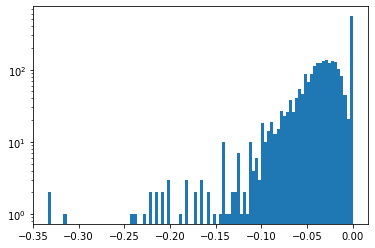

In [556]:
# check how many reviews are missing from the dataset for each business
rcd = pd.merge(num_reviews,business_df,on='business_id')[['business_id','name','num_reviews_in_dataset','review_count']]
rcd['review_count_difference'] = (rcd.review_count - rcd.num_reviews_in_dataset)/rcd.review_count
plt.hist(rcd.review_count_difference,bins=100)
plt.yscale('log')
plt.show()

In [555]:
rcd['review_count_difference'].value_counts()

 0.000000    552
-0.045455     19
-0.041667     18
-0.050000     16
-0.043478     16
            ... 
-0.022989      1
-0.087719      1
-0.023962      1
-0.004505      1
-0.011561      1
Name: review_count_difference, Length: 1100, dtype: int64

# combine review and business data

## score based on review date

Let's strip the dataframes of all unnecessary features, leaving only the business_id, inspection score & date, review score & date. Then we look for the inspection nearest to each individual review in time, and use that inspection score for the 'cleanliness' of the business at the time of the review.

We set a tolerance of 2 years to exclude all reviews that are 2 years away from an inspection. This limits us to reviews posted from 2017 to 2021, cutting down the dataset by 50%.

In [6]:
business_df_latest = pd.read_csv(processed_data_directory + 'business_df_latest_inspection.csv')
business_df = pd.read_csv(processed_data_directory + 'business_df.csv')
review_df = pd.read_csv(processed_data_directory + 'review_df.csv')

In [5]:
bare_bones_bdf = business_df[['business_id','Inspection Date','Score','stars']].rename({'Inspection Date':'date'},axis=1).copy()
bare_bones_bdf['date'] = pd.to_datetime(bare_bones_bdf['date'])

In [6]:
bare_bones_rdf = review_df[['business_id','review_id','text','date','review_stars']].copy()
bare_bones_rdf['date'] = pd.to_datetime(bare_bones_rdf['date'])
bare_bones_rdf

,business_id,review_id,text,date,review_stars
0,mOnesB4IF9j6-ZmHoOHOig,GDgXjXSZCA1iNQWD7OHXfg,I think their rice dishes are way better than ...,2017-05-26 03:05:46,4
1,-_GnwXmzC3DXsHR9nyaC2g,GgWFjRHhelaiUgR2-H6N4g,3.5 stars! I got the avocado margarita and it ...,2012-11-06 07:09:57,3
2,bZiIIUcpgxh8mpKMDhdqbA,z-6ElnK3yXpn2oNKR7NYtw,My husband and I shared the parmesan truffly f...,2017-10-11 00:25:47,3
3,gvpoFnaCq2J7TBXV7yFIkQ,nqUJoSkDr_1mqnLtOrWFSA,"Perfect spices, nice atmosphere & music, great...",2017-07-28 19:17:54,5
4,LUCmOKTK5Uh7eU84yJq3mQ,h6o5mduBqDUkKsa4KRIDzw,Snap is my go-to lunch spot nearly every day! ...,2015-06-08 18:07:06,5
...,...,...,...,...,...
570609,dgywJM4JpniwOEDNfrfewg,I_8BJ6vZo7mVHi4TzuEK2A,I rec'd my meal as part of a complimentary Yel...,2020-08-09 19:53:40,2
570610,Qmq4gr5Mmo2oIVejag48PA,oabuTmGpHquA4sc4C0DatQ,This place serves amazingly tasty gluten free ...,2020-09-13 00:53:03,4
570611,zM98ZSIJyuBQabyYornLpw,hKxvxtCjEJAwD_7AcnA_iQ,Bartender was friendly and attentive. We came ...,2021-01-10 04:10:45,3
570612,Wn8j-1-ity6hdjP4bC_wkw,UWHPbsQzfrmjtDCbq2AeDg,Terrible pho. Literally zero flavor. And the c...,2021-01-17 22:09:10,2


In [7]:
business_ids = bare_bones_bdf.business_id.unique()

In [8]:
%%time
# merge score and review dataframes based on closeness in time
# needs to be done in a loop over business_id because merge_asof only works with one column
biz_df_list = []
tolerance = pd.Timedelta(days = 365*20) # two year tolerance
for bid in business_ids:
    indiv_biz_scores = bare_bones_bdf[bare_bones_bdf['business_id']==bid]
    indiv_biz_reviews = bare_bones_rdf[bare_bones_rdf['business_id']==bid].sort_values('date')
    out = pd.merge_asof(indiv_biz_reviews,indiv_biz_scores,on='date',direction='nearest',tolerance=tolerance).dropna()
    out = out.drop('business_id_y',axis=1).rename(columns={'business_id_x':'business_id'})
    biz_df_list.append(out)

Wall time: 2min 27s


In [9]:
df = pd.concat(biz_df_list, ignore_index=True, join='outer', axis=0)
df.to_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv', index=False)

In [10]:
sorted(df['date'])[0]

Timestamp('2005-05-14 07:04:06')

In [11]:
sorted(df['date'])[-1]

Timestamp('2021-01-28 15:30:21')

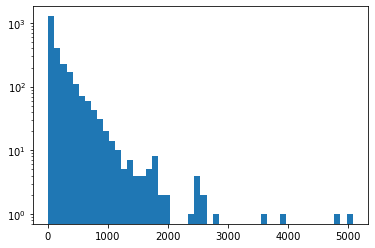

In [12]:
# review distribution
plt.hist(df.business_id.value_counts(), bins=50)
plt.yscale('log')

## some more processing

* reviews_nearest_score_2_years_df.csv : only taking reviews within 2 years of an inspection
* reviews_nearest_score_no_limit_df.csv : taking nearest inspection for all reviews

In [13]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
df2 = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [14]:
len(df)

570614

In [15]:
len(df2)

216617

In [ ]:
# # discard businesses with < 10 reviews
# n = 10
# less_than_n_reviews = df.business_id.value_counts()[df.business_id.value_counts() < n].index
# df = df[~df['business_id'].isin(less_than_n_reviews)]

# old stuff

In [488]:
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
df.to_csv(processed_data_directory + 'review_df.csv', index=False)

In [131]:
num_reviews = df.groupby('business_id').size()

In [135]:
num_reviews[num_reviews==max(num_reviews)]

business_id
5y2zZGIE2a4tuEJ5FhSVrQ    10408
dtype: int64

In [483]:
chunk.columns

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'useful',
       'funny', 'cool', 'text', 'date'],
      dtype='object')

In [484]:
test.columns

Index(['business_id', 'name', 'address', 'latitude', 'longitude', 'stars',
       'review_count', 'is_open', 'attributes', 'categories',
       'Inspection Date', 'Score', 'review_id', 'user_id', 'review_stars',
       'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')

In [224]:
chunk.drop_duplicates()[chunk.drop_duplicates().review_id == 'oSMFCnRSQPgbvAieltqBIA']

,business_id,Facility ID,review_count,stars,Score,Inspection Date,is_open,review_id,user_id,review_stars,useful,funny,cool,text,date
26246,OUR3sFpDJYdTcMNyMV6SBQ,11377984,113,3.5,85,2021-04-13,1,oSMFCnRSQPgbvAieltqBIA,TAYK9BTjGPXFL1ChIwuxsg,2,1,1,0,"During my recent trip to Austin, I decided to ...",2011-07-04 04:39:38
26328,OUR3sFpDJYdTcMNyMV6SBQ,11377963,113,3.5,85,2022-01-13,1,oSMFCnRSQPgbvAieltqBIA,TAYK9BTjGPXFL1ChIwuxsg,2,1,1,0,"During my recent trip to Austin, I decided to ...",2011-07-04 04:39:38
26410,OUR3sFpDJYdTcMNyMV6SBQ,11377975,113,3.5,85,2022-01-13,1,oSMFCnRSQPgbvAieltqBIA,TAYK9BTjGPXFL1ChIwuxsg,2,1,1,0,"During my recent trip to Austin, I decided to ...",2011-07-04 04:39:38


In [222]:
chunk[chunk.review_id == 'oSMFCnRSQPgbvAieltqBIA']

,business_id,Facility ID,review_count,stars,Score,Inspection Date,is_open,review_id,user_id,review_stars,useful,funny,cool,text,date
26246,OUR3sFpDJYdTcMNyMV6SBQ,11377984,113,3.5,85,2021-04-13,1,oSMFCnRSQPgbvAieltqBIA,TAYK9BTjGPXFL1ChIwuxsg,2,1,1,0,"During my recent trip to Austin, I decided to ...",2011-07-04 04:39:38
26328,OUR3sFpDJYdTcMNyMV6SBQ,11377963,113,3.5,85,2022-01-13,1,oSMFCnRSQPgbvAieltqBIA,TAYK9BTjGPXFL1ChIwuxsg,2,1,1,0,"During my recent trip to Austin, I decided to ...",2011-07-04 04:39:38
26410,OUR3sFpDJYdTcMNyMV6SBQ,11377975,113,3.5,85,2022-01-13,1,oSMFCnRSQPgbvAieltqBIA,TAYK9BTjGPXFL1ChIwuxsg,2,1,1,0,"During my recent trip to Austin, I decided to ...",2011-07-04 04:39:38


In [221]:
chunk.review_id.value_counts()

oSMFCnRSQPgbvAieltqBIA    3
SLVjTJKfhPKX5aeJedYkEg    3
4RmXSTlSoMXt7QTADWnqbA    3
1GJO8BltYHohaTNomxdjEw    3
fwHFYfE-6MvDxLr_aDrmag    3
                         ..
2q5dUBdhYNceDqjBCDbW9w    1
QTBa-iNLh9cgOIygGenN8w    1
oV-YeAJeqIWvdUpbmx18yQ    1
qMOZXbqw2Bc_oGFsSMz3ZQ    1
UkXyaOJej3sAahW0UfMzyA    1
Name: review_id, Length: 45301, dtype: int64

In [219]:
chunk.review_id.unique().shape

(45301,)

In [ ]:
test.merge(chunk.drop_duplicates(),on='business_id','review_id'

In [210]:
test.drop_duplicates()

,business_id,Facility ID,review_count,stars,Score,Inspection Date,is_open,review_stars,text,date
0,NRPemqVb4qpWFF0Avq_6OQ,11673927,395,4.5,75,2021-11-29,1,5,"Don't change a thing, Eurasia!! This place has...",2018-10-04 16:09:21
1,NRPemqVb4qpWFF0Avq_6OQ,11673927,395,4.5,75,2021-11-29,1,5,Best sushi in Austin! Just missing the live mu...,2017-08-16 12:33:46
2,NRPemqVb4qpWFF0Avq_6OQ,11673927,395,4.5,75,2021-11-29,1,4,We came on an off hour so it would hard to jud...,2018-03-15 21:44:28
3,NRPemqVb4qpWFF0Avq_6OQ,11673927,395,4.5,75,2021-11-29,1,5,This place is totally delicious and reasonably...,2017-12-29 23:21:24
4,NRPemqVb4qpWFF0Avq_6OQ,11673927,395,4.5,75,2021-11-29,1,1,My husband and I came opening weekend and love...,2018-02-24 14:24:35
...,...,...,...,...,...,...,...,...,...,...
47747,cH2OHLE72-GNs8naH5u-2A,11096134,15,3.5,96,2021-03-26,1,4,Cheap stuff. That's all that can be said. Grea...,2015-12-07 17:05:53
47748,cH2OHLE72-GNs8naH5u-2A,11096134,15,3.5,96,2021-03-26,1,1,"First time in a Big Lots and kinda impressed, ...",2014-11-02 22:45:43
47749,cH2OHLE72-GNs8naH5u-2A,11096134,15,3.5,96,2021-03-26,1,1,First time here and the worst experience ever....,2015-12-26 21:57:08
47750,cH2OHLE72-GNs8naH5u-2A,11096134,15,3.5,96,2021-03-26,1,2,"Yes, I agree Big Lots has lots of stuff, but v...",2012-03-16 16:47:42


In [204]:
2715-(47752-45301)

264

In [200]:
business_df.shape

(2715, 7)

In [180]:
test = chunk.copy()

In [185]:
chunk[~chunk['business_id'].isin(business_ids)]

,business_id,review_stars,text,date


In [203]:
len(test.business_id.unique())

227

In [207]:
len(chunk.business_id.unique())

227

In [154]:
chunk[chunk['business_id'] == 'NRPemqVb4qpWFF0Avq_6OQ']

,business_id,Facility ID,review_count,stars,Score,Inspection Date,is_open,review_stars,text,date
0,NRPemqVb4qpWFF0Avq_6OQ,11673927,395,4.5,75,2021-11-29,1,5,"Don't change a thing, Eurasia!! This place has...",2018-10-04 16:09:21
1,NRPemqVb4qpWFF0Avq_6OQ,11673927,395,4.5,75,2021-11-29,1,5,Best sushi in Austin! Just missing the live mu...,2017-08-16 12:33:46
2,NRPemqVb4qpWFF0Avq_6OQ,11673927,395,4.5,75,2021-11-29,1,4,We came on an off hour so it would hard to jud...,2018-03-15 21:44:28
3,NRPemqVb4qpWFF0Avq_6OQ,11673927,395,4.5,75,2021-11-29,1,5,This place is totally delicious and reasonably...,2017-12-29 23:21:24
4,NRPemqVb4qpWFF0Avq_6OQ,11673927,395,4.5,75,2021-11-29,1,1,My husband and I came opening weekend and love...,2018-02-24 14:24:35
...,...,...,...,...,...,...,...,...,...,...
171,NRPemqVb4qpWFF0Avq_6OQ,11673927,395,4.5,75,2021-11-29,1,4,We have ordered takeout and delivery from here...,2018-11-05 18:17:25
172,NRPemqVb4qpWFF0Avq_6OQ,11673927,395,4.5,75,2021-11-29,1,4,"Okay, I eat here at least once every other wee...",2018-10-25 02:35:44
173,NRPemqVb4qpWFF0Avq_6OQ,11673927,395,4.5,75,2021-11-29,1,4,This place is very good for a strip mall sushi...,2018-03-10 18:01:50
174,NRPemqVb4qpWFF0Avq_6OQ,11673927,395,4.5,75,2021-11-29,1,5,I've been to this restaurant a handful of time...,2018-04-03 23:38:34


In [151]:
chunk.drop(['review_id','user_id','useful','funny','cool'], axis=1).reset_index(drop=True)

KeyError: "['review_id', 'user_id', 'useful', 'funny', 'cool'] not found in axis"

In [106]:
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
df.to_csv(processed_data_directory + 'review_df.csv', index=False)

In [130]:
df['review_count']

0         395
1         395
2         395
3         395
4         395
         ... 
619063     83
619064     83
619065     83
619066     83
619067     83
Name: review_count, Length: 619068, dtype: int64

In [131]:
num_reviews = df.groupby('business_id').size()

In [135]:
num_reviews[num_reviews==max(num_reviews)]

business_id
5y2zZGIE2a4tuEJ5FhSVrQ    10408
dtype: int64

In [193]:
aa = df[df['business_id']=='5y2zZGIE2a4tuEJ5FhSVrQ']['text']

In [195]:
aa[aa.str.len() < 5]

284843    HUGE
284962       .
285779    HUGE
285898       .
286715    HUGE
286834       .
287651    HUGE
287770       .
288587    HUGE
288706       .
289523    HUGE
289642       .
290459    HUGE
290578       .
291395    HUGE
291514       .
Name: text, dtype: object

In [126]:
num_reviews[num_reviews == 5]

business_id
2QbBG82KI0wV20TiyfphSA    5
4qhWTv-dNzCLPTHUCiL-mQ    5
8FWYHzy-ibeJ1mwaw560Vg    5
CtEGObFKWrjoCw5yh3Nj5w    5
EHJme7HnwXdQsmcR2FpevQ    5
FXs03HmN_vW8axbAB7lG1w    5
Fqk6LWmLVGMAoivmBDLMKg    5
Ft7L5iVsfhQMH25QZNl-Wg    5
Iww97pPi00RAilMNSap_qw    5
Klx35uo2nXmlbVg9WV8sfA    5
L8GVB38wwTl8edp7cJ_s3w    5
OKBeFwn2YJykaST3t9uR7A    5
PWlCzun4rtaBaY7mEHHQOg    5
PwnclsrDATTtyhYzYhOvOA    5
SKHrI_J_39UNRw2p5HPZ7A    5
TXa6-EBkQahlEUSVQUySPg    5
TxyUInLFr5Z1ubTOCYysHQ    5
VQ_iFiWpIHlxuXPJT-MApQ    5
Vx3F_LgMWgy0zOffLxAiEg    5
Xuyhiot1YNPmb6iFbdbbng    5
YmR7IFpYinUqbIfKEzjZGQ    5
_UssSPp_h9xbT5JhulzV9A    5
a1sdhCOIfwMMWhSMiRwsGQ    5
dFRLf3DYJyUrPMMnT7NEZw    5
eQ4JaVlVxmJc647OQHC_kQ    5
idDWnLLohZCl7bVEkBI9Xw    5
qK3n6bsaYXSyY3bbzeC6hg    5
tqHZ-qFUH34Juvw_IQqWvA    5
vwyGvxZsMHwsHbTv_bc_WA    5
wNFHDbCd1kvN-dRFksVAfw    5
ySjteVMazjUzfov9czGLYQ    5
dtype: int64

In [123]:
max(num_reviews)

10408

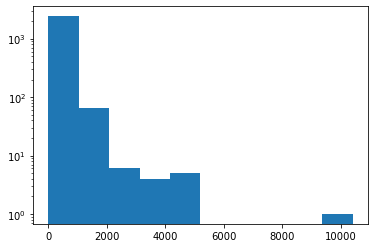

In [120]:
plt.hist(num_reviews)
plt.yscale('log')

In [105]:
len(business_df.business_id.unique())

2506

In [104]:
len(df.business_id.unique())

2506

In [ ]:
# Renaming column name to avoid conflict with business overall star rating
chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
# Inner merge with edited business file so only reviews related to the business remain
chunk_merged = pd.merge(business_RV, chunk_review, on='business_id', how='inner')
# Show feedback on progress
print(f"{chunk_merged.shape[0]} out of {size:,} related reviews")
chunk_list.append(chunk_merged)

In [ ]:
chunk_list = []
for chunk in json_reader:
    # Drop columns that aren't needed
    chunk = chunk.drop(['review_id','user_id','useful','funny','cool'], axis=1)
    # Renaming column name to avoid conflict with business overall star rating
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    # Inner merge with edited business file so only reviews related to the business remain
    chunk_merged = pd.merge(business_RV, chunk_review, on='business_id', how='inner')
    # Show feedback on progress
    print(f"{chunk_merged.shape[0]} out of {size:,} related reviews")
    chunk_list.append(chunk_merged)
# After trimming down the review file, concatenate all relevant data back to one dataframe
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

In [143]:
path = yelp_data_directory + 'yelp_academic_dataset_business.json'
df_r = pd.read_json(path, lines=True)

In [144]:
df_r

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160580,D2mHoIDXx9N8mS1pGoKV9Q,Eleven Oaks Realty,,Austin,TX,78701,30.272921,-97.744386,4.0,8,1,None,"Real Estate, Real Estate Services, Home Servic...","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."
160581,bQX-kwVTyZgcdZGEPzce6Q,Webb's Honey,21777 State Rd 520,Orlando,FL,32833,28.499836,-81.047478,4.5,18,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsPri...","Health Markets, Food, Specialty Food, Grocery","{'Monday': '10:0-18:0', 'Tuesday': '10:0-18:0'..."
160582,wvFZ06nmPmQ2-IVoPqVYLA,Painting with a Twist,2164 S Chickasaw Trl,Orlando,FL,32825,28.511615,-81.270020,5.0,8,0,"{'DogsAllowed': 'False', 'ByAppointmentOnly': ...","Arts & Entertainment, Paint & Sip, Art Classes...","{'Monday': '0:0-0:0', 'Wednesday': '12:0-17:0'..."
160583,GB75wPibj3IjNauaoCxyGA,Havana Cafe,910 NW 14th St,Portland,OR,97209,45.529647,-122.685153,4.0,10,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsDel...","Cuban, Sandwiches, Restaurants, Cafes",None


In [ ]:
austin_businesses = df_b[(df_b.city == 'Austin') & (~df_b.categories.isna())]
austin_restaurants = austin_businesses[austin_businesses.categories.str.contains('Restaurants|Food')].reset_index(drop=True)
austin_restaurants[austin_restaurants.name.str.contains('Hunan')]

# old junk

## determining which city to choose

### live dataset from yelp

In [48]:
data_directory = r'C:\Users\ASUS\Desktop\ML-data science\DataIncubator\yelp-cleaners\yelp_dataset' + '\\'
path = data_directory + 'yelp_academic_dataset_business.json'
df_b = pd.read_json(path, lines=True)

In [49]:
df_b.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [68]:
df = df_b.dropna()

In [74]:
df[df.dropna().categories.str.contains('Food|Restaurant') & df.city == 'Santa Barbara']

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours


In [79]:
df[df['city']=='Santa Barbara'][df.dropna().categories.str.contains('Restaurant')]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17616\1665998319.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['city']=='Santa Barbara'][df.dropna().categories.str.contains('Restaurant')]


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
85,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': '...","Food, Restaurants, Salad, Coffee & Tea, Breakf...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', '..."
141,SZU9c8V2GuREDN5KgyHFJw,Santa Barbara Shellfish Company,230 Stearns Wharf,Santa Barbara,CA,93101,34.408715,-119.685019,4.0,2404,1,"{'OutdoorSeating': 'True', 'RestaurantsAttire'...","Live/Raw Food, Restaurants, Seafood, Beer Bar,...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
431,ifjluUv4VASwmFqEp8cWlQ,Marty's Pizza,2733 De La Vina St,Santa Barbara,CA,93105,34.436236,-119.726147,4.0,64,1,"{'Alcohol': 'u'none'', 'BusinessAcceptsCreditC...","Pizza, Restaurants","{'Tuesday': '11:0-21:30', 'Wednesday': '11:0-2..."
1320,UFpCraqzFBAhtZqmxmiWsA,Cat Therapy,"1213 State St, Ste L",Santa Barbara,CA,93101,34.423302,-119.705471,4.5,116,1,"{'WheelchairAccessible': 'True', 'WiFi': 'u'fr...","Themed Cafes, Cafes, Pets, Arts & Entertainmen...","{'Monday': '10:0-17:15', 'Wednesday': '10:0-19..."
1417,Hqz96v1ymucUKNzIWfEKXw,Subway,"1936 State St, Ste B",Santa Barbara,CA,93101,34.430822,-119.714156,3.0,5,0,"{'Alcohol': 'u'none'', 'Caters': 'True', 'Bike...","Restaurants, Delis, Sandwiches, Fast Food","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149317,HrnSaz2f1WUEoAQQ6iD6gw,Lemon Tree Inn,2819 State St,Santa Barbara,CA,93105,34.438226,-119.725035,2.5,270,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Restaurants, Nightlife, Hotels & Travel, Hotel...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
149461,Hlx8S2GLF7hMuIKx4sU-gg,Cesar's Place,712 N Milpas St,Santa Barbara,CA,93103,34.428599,-119.688223,4.0,117,1,"{'BYOBCorkage': ''no'', 'RestaurantsReservatio...","Mexican, Restaurants, Fish & Chips","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
149493,bVaRZDHkWdsHuARGxxpREw,Sushi Bar 29,1134 Chapala St,Santa Barbara,CA,93101,34.422291,-119.705339,4.5,97,1,"{'WiFi': 'u'no'', 'RestaurantsTableService': '...","Japanese, Restaurants, Noodles, Sushi Bars","{'Monday': '17:0-21:30', 'Tuesday': '17:0-21:3..."
150169,izSgTrqebu8bN8ONOCs6cQ,Oat Bakery,5 W Haley St,Santa Barbara,CA,93101,34.416548,-119.695626,5.0,123,1,"{'Alcohol': 'u'none'', 'HasTV': 'False', 'Bike...","Bakeries, Vegan, Specialty Food, Food Delivery...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-18:0', '..."


In [99]:
cities = df_b.city.value_counts()[:100]
print(cities.to_string())

Philadelphia        14569
Tucson               9250
Tampa                9050
Indianapolis         7540
Nashville            6971
New Orleans          6209
Reno                 5935
Edmonton             5054
Saint Louis          4827
Santa Barbara        3829
Boise                2937
Clearwater           2221
Saint Petersburg     1663
Metairie             1643
Sparks               1624
Wilmington           1446
Franklin             1414
St. Louis            1255
St. Petersburg       1185
Meridian             1043
Brandon              1033
Largo                1002
Carmel                967
Cherry Hill           960
West Chester          838
Goleta                798
Brentwood             767
Palm Harbor           665
Greenwood             649
New Port Richey       604
Lutz                  591
Riverview             588
Kenner                584
Fishers               570
King of Prussia       560
Wesley Chapel         560
Doylestown            539
Pinellas Park         512
Dunedin     

In [40]:
latlong = df_b[['latitude','longitude']]
# latlong = latlong[:1000]
# latlong

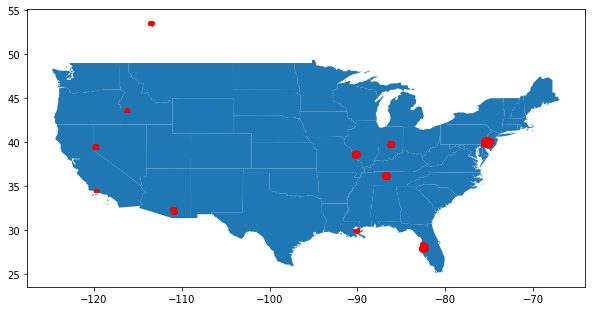

In [41]:
map_path = r'C:\Users\ASUS\Desktop\ML-data science\DataIncubator\yelp-cleaners\data\states_21basic\states.shp'

geometry = [Point(xy) for xy in zip(latlong['longitude'], latlong['latitude'])]
gdf = GeoDataFrame(latlong, geometry=geometry)   

usa = gpd.read_file(map_path)
usa = usa[~usa['STATE_NAME'].isin(['Hawaii','Alaska'])] # exclude HI & AK
gdf.plot(ax=usa.plot(figsize=(10, 6)), marker='o', color='red', markersize=2, alpha=0.2);

### different datasets from kaggle

In [115]:
map_path = r'C:\Users\ASUS\Desktop\ML-data science\DataIncubator\yelp-cleaners\data\states_21basic\states.shp'
def show_cities(dataset=2,print_cities=True,plot_cities=True):
    data_directory = r'C:\Users\ASUS\Desktop\ML-data science\DataIncubator\yelp-cleaners\data\old yelp data' + '\\'
    path = data_directory + 'yelp_academic_dataset_business_version{}.json'.format(dataset)
    df_b = pd.read_json(path, lines=True)

    cities = df_b.city.value_counts()[:100]
    if print_cities:
        print(cities.to_string())

    latlong = df_b[['latitude','longitude']]

    if plot_cities:
        geometry = [Point(xy) for xy in zip(latlong['longitude'], latlong['latitude'])]
        gdf = GeoDataFrame(latlong, geometry=geometry)   
        usa = gpd.read_file(map_path)
        usa = usa[~usa['STATE_NAME'].isin(['Hawaii','Alaska'])] # exclude HI & AK
        gdf.plot(ax=usa.plot(figsize=(10, 6)), marker='o', color='red', markersize=2, alpha=0.2)

In [116]:
datasets = [2,3,4,7,9]

Las Vegas             31631
Toronto               20366
Phoenix               20171
Charlotte             10422
Scottsdale             9342
Calgary                8377
Pittsburgh             7630
Montréal               6979
Mesa                   6577
Henderson              5272
Tempe                  4797
Chandler               4580
Cleveland              3857
Glendale               3824
Gilbert                3745
Madison                3685
Mississauga            3518
Peoria                 2080
Markham                1963
North Las Vegas        1677
Champaign              1327
North York             1319
Scarborough            1244
Surprise               1218
Richmond Hill          1153
Brampton               1146
Concord                1125
Vaughan                1045
Goodyear                951
Etobicoke               841
Matthews                812
Avondale                745
Fort Mill               696
Huntersville            684
Gastonia                564
Lakewood            

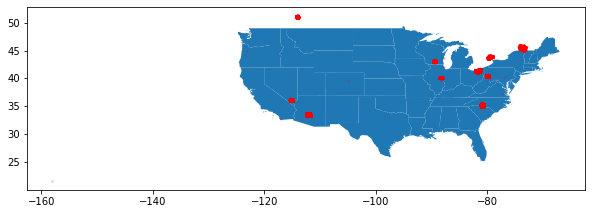

In [117]:
show_cities(2)

Austin               22416
Portland             18203
Vancouver            13330
Atlanta              12612
Orlando              10637
Boston                8263
Columbus              6634
Boulder               2542
Cambridge             2433
Beaverton             2252
Richmond              1791
Burnaby               1725
Kissimmee             1713
Decatur               1411
Winter Park           1288
Somerville            1265
Quincy                1093
Brookline              986
North Vancouver        926
Tigard                 916
Waltham                883
Newton                 823
Smyrna                 820
Altamonte Springs      783
Lake Oswego            761
Dublin                 734
Salem                  721
Sanford                672
Natick                 669
Medford                668
Coquitlam              652
Woburn                 618
Watertown              607
Peabody                602
Burlington             595
Oviedo                 584
Braintree              577
W

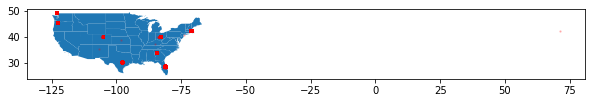

In [118]:
show_cities(3)

Philadelphia        14569
Tucson               9250
Tampa                9050
Indianapolis         7540
Nashville            6971
New Orleans          6209
Reno                 5935
Edmonton             5054
Saint Louis          4827
Santa Barbara        3829
Boise                2937
Clearwater           2221
Saint Petersburg     1663
Metairie             1643
Sparks               1624
Wilmington           1446
Franklin             1414
St. Louis            1255
St. Petersburg       1185
Meridian             1043
Brandon              1033
Largo                1002
Carmel                967
Cherry Hill           960
West Chester          838
Goleta                798
Brentwood             767
Palm Harbor           665
Greenwood             649
New Port Richey       604
Lutz                  591
Riverview             588
Kenner                584
Fishers               570
King of Prussia       560
Wesley Chapel         560
Doylestown            539
Pinellas Park         512
Dunedin     

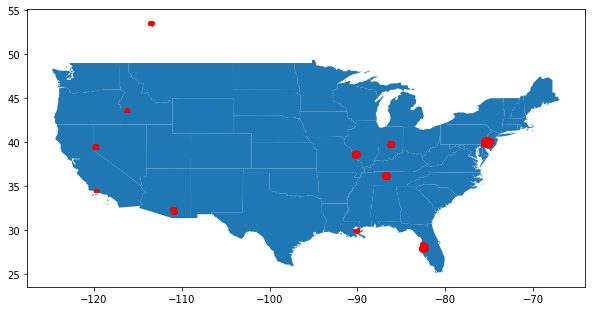

In [119]:
show_cities(4)

Las Vegas            28865
Phoenix              18633
Toronto              18233
Charlotte             9204
Scottsdale            8822
Calgary               7384
Pittsburgh            6804
Mesa                  6239
Montréal              6045
Henderson             4815
Tempe                 4492
Chandler              4272
Madison               3509
Cleveland             3506
Glendale              3469
Gilbert               3397
Mississauga           2954
Peoria                1868
Markham               1699
North Las Vegas       1508
Champaign             1243
Scarborough           1175
North York            1140
Surprise              1119
Richmond Hill          978
Concord                975
Brampton               929
Vaughan                853
Goodyear               827
Etobicoke              760
Matthews               726
Oakville               699
Avondale               663
Fort Mill              620
Huntersville           608
Lakewood               509
Gastonia               494
C

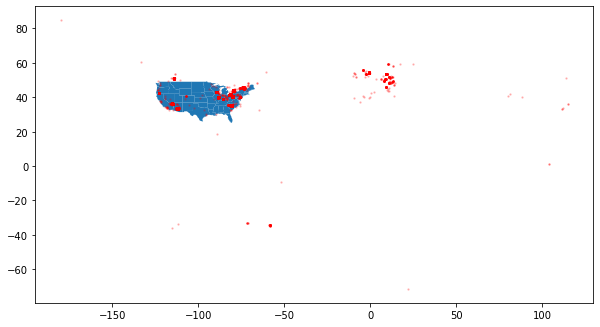

In [120]:
show_cities(7)

Las Vegas             29370
Toronto               18906
Phoenix               18766
Charlotte              9509
Scottsdale             8837
Calgary                7736
Pittsburgh             7017
Montréal               6449
Mesa                   6080
Henderson              4892
Tempe                  4550
Chandler               4309
Cleveland              3605
Glendale               3543
Madison                3494
Gilbert                3462
Mississauga            3112
Peoria                 1919
Markham                1766
North Las Vegas        1548
Champaign              1262
North York             1205
Surprise               1148
Scarborough            1103
Richmond Hill          1026
Brampton               1002
Concord                 990
Vaughan                 919
Goodyear                855
Etobicoke               793
Matthews                749
Avondale                681
Fort Mill               627
Huntersville            625
Lakewood                519
Gastonia            

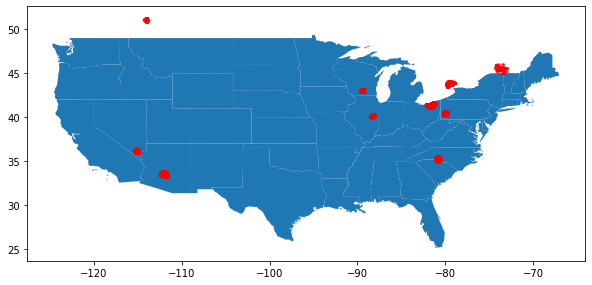

In [121]:
show_cities(9)

## LA inspection data

### 2015-2018 LA restaurant inspections

Found a 2015-2018 dataset at https://data.lacity.org/Community-Economic-Development/Restaurant-and-Market-Health-Inspections/29fd-3paw, exported as CSV file. Can also access json entries via their API.

In [82]:
df = pd.read_csv('data/Los Angeles/Restaurant_and_Market_Health_Inspections.csv')

In [83]:
df.columns

Index(['serial_number', 'activity_date', 'facility_name', 'score', 'grade',
       'service_code', 'service_description', 'employee_id',
       'facility_address', 'facility_city', 'facility_id', 'facility_state',
       'facility_zip', 'owner_id', 'owner_name', 'pe_description',
       'program_element_pe', 'program_name', 'program_status', 'record_id'],
      dtype='object')

In [84]:
df.facility_address

0               3708 N EAGLE ROCK BLVD
1                  100 WORLD WAY # 120
2            6801 HOLLYWOOD BLVD # 253
3                   1814 W SUNSET BLVD
4                   2100 ECHO PARK AVE
                     ...              
67568    104 JAPANESE VILLAGE PLZ MALL
67569           4050 W WASHINGTON BLVD
67570                     4312 WALL ST
67571               2012 SAWTELLE BLVD
67572        3600 E CESAR E CHAVEZ AVE
Name: facility_address, Length: 67573, dtype: object

In [85]:
df.activity_date = pd.to_datetime(df.activity_date)

In [86]:
print(min(df.activity_date))
print(max(df.activity_date))

2015-07-01 00:00:00
2018-07-31 00:00:00


In [87]:
len(pd.unique(df.facility_name))

12071

In [88]:
df[["score","grade"]].groupby('grade').agg({"score": [min, np.mean, max]})

score                
        min       mean  max
grade                      
         65  65.000000   65
A        90  94.087338  100
B        80  83.788204   89
C        64  74.048193   79

In [97]:
df[df.facility_name.str.contains('BOBA|TEA|COFFEE')].facility_name.value_counts()

THE COFFEE BEAN & TEA LEAF    147
BLUE BOTTLE COFFEE             32
I LOVE BOBA                    27
BOBA TIME                      23
IT'S BOBA TIME                 22
                             ... 
STARBUCKS COFFEE #5296          1
HASHTAG#COFFEE&TEA              1
FICKLE TEA LOUNGE               1
ST VINCENT COFFEE SHOP          1
MEDIDATE COFFEE                 1
Name: facility_name, Length: 378, dtype: int64

In [23]:
df.value_counts('facility_name')

facility_name
DODGER STADIUM           464
STAPLES CENTER (LEVY)    290
LA COLISEUM              225
WHOLE FOODS MARKET       208
SUBWAY                   155
                        ... 
THE PIANO BAR              1
ANZIO CAFE                 1
FUEGO NIGHT CLUB           1
QDOBA MEXICAN GRILL        1
MARKS LIQUOR               1
Length: 12071, dtype: int64

In [26]:
df.value_counts('facility_id')

facility_id
FA0019271    464
FA0006427    290
FA0065100    225
FA0024180    117
FA0156500    103
            ... 
FA0247928      1
FA0042091      1
FA0163817      1
FA0042050      1
FA0262447      1
Length: 13545, dtype: int64

In [30]:
df.facility_address == "3708 N EAGLE ROCK BLVD"

0         True
1        False
2        False
3        False
4        False
         ...  
67568    False
67569    False
67570    False
67571    False
67572    False
Name: facility_address, Length: 67573, dtype: bool

### more recent LA restaurant inspections

More recent but smaller dataset at https://ehservices.publichealth.lacounty.gov/ezsearch

In [75]:
columns = ['facility_name','inspection_date','score','facility_address','facility_city']
df = pd.read_csv('inspections.csv',names=columns)
# lots of restaurants without scores, weirdly
df = df.dropna().reset_index(drop=True)

In [76]:
df.value_counts('facility_address')

facility_address
762 E SLAUSON AVE         222
7782 SAN FERNANDO RD      145
100 UNIVERSAL CITY PLZ    138
1000 S PRAIRIE AVE        126
1000 VIN SCULLY AVE       118
                         ... 
18438 COLIMA RD 12          1
18438 COLIMA RD #105        1
18438 COLIMA # 1            1
18434 DEVONSHIRE ST         1
S VERMONT AVE               1
Length: 35749, dtype: int64

lots of wrong addresses here... e.g., "TAQUERIA SAN MIGUEL ESTILO TIJUANA" is on Yelp at 1012 Hooper Ave ( https://www.yelp.com/biz/taqueria-san-miguel-los-angeles )

In [79]:
# lots of wrong addresses here
# e.g., "TAQUERIA SAN MIGUEL ESTILO TIJUANA" is on Yelp at 
df[df.facility_address == '762 E SLAUSON AVE']

,facility_name,inspection_date,score,facility_address,facility_city
172,TAQUERIA SAN MIGUEL ESTILO TIJUANA,2022-01-25,93.0,762 E SLAUSON AVE,LOS ANGELES
545,TACOS MR.HIDRO,2019-09-23,90.0,762 E SLAUSON AVE,LOS ANGELES
568,CELIA'S FOODS,2020-06-22,97.0,762 E SLAUSON AVE,LOS ANGELES
667,PALOMA CELESTIAL #2,2022-03-22,94.0,762 E SLAUSON AVE,LOS ANGELES
1111,LOS AMIGOS FOOD TRUCK,2022-02-24,90.0,762 E SLAUSON AVE,LOS ANGELES
...,...,...,...,...,...
44895,CHICKEN KING FT,2021-10-30,95.0,762 E SLAUSON AVE,LOS ANGELES
44918,ESPERANZA TACOS GRILL,2022-02-24,90.0,762 E SLAUSON AVE,LOS ANGELES
44929,TACOS LOS AMIGOS,2022-03-17,86.0,762 E SLAUSON AVE,LOS ANGELES
44938,GLENDA'S CATERING,2022-03-08,90.0,762 E SLAUSON AVE,LOS ANGELES


In [36]:
df.columns

Index(['ARIEL COURT APTS SPA POOL', '2020-01-31', 'Unnamed: 2',
       '535 GAYLEY AVE ', 'LOS ANGELES'],
      dtype='object')

In [7]:
df.facility_address

0               3708 N EAGLE ROCK BLVD
1                  100 WORLD WAY # 120
2            6801 HOLLYWOOD BLVD # 253
3                   1814 W SUNSET BLVD
4                   2100 ECHO PARK AVE
                     ...              
67568    104 JAPANESE VILLAGE PLZ MALL
67569           4050 W WASHINGTON BLVD
67570                     4312 WALL ST
67571               2012 SAWTELLE BLVD
67572        3600 E CESAR E CHAVEZ AVE
Name: facility_address, Length: 67573, dtype: object

## query Yelp fusion API for business health scores

The API does not have health scores! This sucks. Time to web scrape instead.

In [5]:
austin_rest = pd.read_csv(processed_data_directory + 'austin_restaurants.csv')

In [6]:
business_id = austin_rest.business_id[1]
business_id

'NRPemqVb4qpWFF0Avq_6OQ'

In [7]:
yelp_api = YelpAPI(api_key, timeout_s=3.0)

In [8]:
query = f'GET https://api.yelp.com/v3/businesses/{business_id}'
query

'GET https://api.yelp.com/v3/businesses/NRPemqVb4qpWFF0Avq_6OQ'

In [9]:
results = yelp_api.business_query(id=business_id)

In [11]:
all_results={}

In [12]:
all_results[business_id] = results

In [13]:
all_results

{'NRPemqVb4qpWFF0Avq_6OQ': {'id': 'NRPemqVb4qpWFF0Avq_6OQ',
  'alias': 'eurasia-sushi-bar-and-seafood-austin-2',
  'name': 'Eurasia Sushi Bar & Seafood',
  'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/u0zypdAOIdkGVxpZWm3w3Q/o.jpg',
  'is_claimed': True,
  'is_closed': False,
  'url': 'https://www.yelp.com/biz/eurasia-sushi-bar-and-seafood-austin-2?adjust_creative=_k6ZLo2AEA8LwUVQTwITpg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_lookup&utm_source=_k6ZLo2AEA8LwUVQTwITpg',
  'phone': '+15123820968',
  'display_phone': '(512) 382-0968',
  'review_count': 456,
  'categories': [{'alias': 'sushi', 'title': 'Sushi Bars'},
   {'alias': 'seafood', 'title': 'Seafood'},
   {'alias': 'cocktailbars', 'title': 'Cocktail Bars'}],
  'rating': 4.5,
  'location': {'address1': '7101 W Hwy 71',
   'address2': 'Ste C-13',
   'address3': '',
   'city': 'Austin',
   'zip_code': '78735',
   'country': 'US',
   'state': 'TX',
   'display_address': ['7101 W Hwy 71', 'Ste C-13', 'Austin, TX 7873

## web scrape health scores from Yelp

This got me banned pretty quickly.

### try manually

In [89]:
austin_rest = pd.read_csv(processed_data_directory + 'austin_restaurants.csv')

In [148]:
len(austin_rest)

6344

In [228]:
business_id = austin_rest.business_id[7]
url = f'https://www.yelp.com/inspections/{business_id}'

In [229]:
business_id

'Pk4ZwXwUU50BDn5gqw_rKg'

In [230]:
response = requests.get(url)
response.status_code

200

In [231]:
# for restaurants without inspection data
if(response.status_code == 404):
    print( None )

In [232]:
soup = BeautifulSoup(response.text)
table = soup.find('table', {'class':'table table-striped js-inspections-table hide-city-grade'})
df_insp = pd.read_html(str(table))[0].drop('Grade',axis=1)
df_insp['business_id'] = business_id
# df_insp.Date = pd.to_datetime(df_insp.Date)

In [233]:
cols = df_insp.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_insp = df_insp[cols]

In [234]:
df_insp

,business_id,Date,Inspection Type,Score
0,Pk4ZwXwUU50BDn5gqw_rKg,"March 31, 2022",Routine,91
1,Pk4ZwXwUU50BDn5gqw_rKg,"September 17, 2021",Routine,85
2,Pk4ZwXwUU50BDn5gqw_rKg,"June 11, 2021",Routine,80
3,Pk4ZwXwUU50BDn5gqw_rKg,"July 9, 2020",Routine,85
4,Pk4ZwXwUU50BDn5gqw_rKg,"March 31, 2020",Routine,94
5,Pk4ZwXwUU50BDn5gqw_rKg,"October 15, 2019",Routine,96


In [220]:
df_insp.to_csv(processed_data_directory + 'inspections_yelp.csv', index=False)

In [244]:
dff = pd.read_csv(processed_data_directory + 'inspections_yelp.csv')

In [245]:
dff

,business_id,Date,Inspection Type,Score
0,bRsDZ44CD3uhGnRY3NeQhQ,"November 8, 2021",Routine,86
1,bRsDZ44CD3uhGnRY3NeQhQ,"July 1, 2021",Routine,78
2,bRsDZ44CD3uhGnRY3NeQhQ,"January 26, 2021",Routine,76
3,bRsDZ44CD3uhGnRY3NeQhQ,"July 6, 2020",Routine,92
4,bRsDZ44CD3uhGnRY3NeQhQ,"January 14, 2020",Routine,80
5,bRsDZ44CD3uhGnRY3NeQhQ,"August 29, 2019",Routine,89
6,Pk4ZwXwUU50BDn5gqw_rKg,"March 31, 2022",Routine,91
7,Pk4ZwXwUU50BDn5gqw_rKg,"September 17, 2021",Routine,85
8,Pk4ZwXwUU50BDn5gqw_rKg,"June 11, 2021",Routine,80
9,Pk4ZwXwUU50BDn5gqw_rKg,"July 9, 2020",Routine,85


In [237]:
df_insp

,business_id,Date,Inspection Type,Score
0,Pk4ZwXwUU50BDn5gqw_rKg,"March 31, 2022",Routine,91
1,Pk4ZwXwUU50BDn5gqw_rKg,"September 17, 2021",Routine,85
2,Pk4ZwXwUU50BDn5gqw_rKg,"June 11, 2021",Routine,80
3,Pk4ZwXwUU50BDn5gqw_rKg,"July 9, 2020",Routine,85
4,Pk4ZwXwUU50BDn5gqw_rKg,"March 31, 2020",Routine,94
5,Pk4ZwXwUU50BDn5gqw_rKg,"October 15, 2019",Routine,96


In [241]:
dff = dff.merge(right=df_insp, how='outer')

In [243]:
dff.to_csv(processed_data_directory + 'inspections_yelp.csv', index=False)

### in a function

In [326]:
url = 'https://www.yelp.com'
headers = { 'user-agent'   : 'TDI-project' }
requests.get(url, headers=headers)

<Response [503]>

In [320]:
requests.get('http://www.yelp.com')


<Response [503]>

In [268]:
def scrape_health_scores(business_id):
    url = f'https://www.yelp.com/inspections/{business_id}'
    response = requests.get(url)
    # for restaurants without inspection data
    if(response.status_code == 404):
        return None
    else:
        table = BeautifulSoup(response.text).find('table', {'class':'table table-striped js-inspections-table hide-city-grade'})
        df_insp = pd.read_html(str(table))[0].drop('Grade',axis=1)
        df_insp['business_id'] = business_id
        return df_insp

In [313]:
austin_rest = pd.read_csv(processed_data_directory + 'austin_restaurants.csv')
business_id = austin_rest.business_id[0]
df = scrape_health_scores(business_id)

ValueError: No tables found

In [315]:
f'https://www.yelp.com/inspections/{business_id}'

'https://www.yelp.com/inspections/Xw8tuI30T-xihpzwBV-zJg'

In [270]:
df_tot = pd.read_csv(processed_data_directory + 'inspections_yelp.csv')

In [271]:
df = scrape_health_scores(business_id)
if df is not None:
    df_tot = df_tot.merge(right=df, how='outer')

In [272]:
df_tot.to_csv(processed_data_directory + 'inspections_yelp.csv', index=False)

In [ ]:
austin_rest = pd.read_csv(processed_data_directory + 'austin_restaurants.csv')

In [287]:
df_tot = pd.DataFrame({})

In [302]:
# initialize with first restaurant with health_scores
business_id = austin_rest.business_id[1]
time.sleep(0.5)
df_tot = scrape_health_scores(business_id)
df_tot.to_csv(processed_data_directory + 'inspections_yelp.csv',index=False)

In [310]:
len(austin_rest)*17.8/20/60.

94.10266666666668

In [311]:
%%time
df_tot = pd.read_csv(processed_data_directory + 'inspections_yelp.csv')
no_health_scores = []
# for idx in range(len(austin_rest)):
for idx in range(0,1000):
    if idx%50 == 0:
        print('Running: '+str(idx))
    business_id = austin_rest.business_id[idx]
    time.sleep(0.5)
    df = scrape_health_scores(business_id)
    if df is None:
        no_health_scores.append(business_id)
    else:
        df_tot = df_tot.merge(right=df, how='outer')
df_tot.to_csv(processed_data_directory + 'inspections_yelp.csv',index=False)

Running: 0


ValueError: No tables found

In [283]:
df_tot

,Unnamed: 0,business_id,Date,Inspection Type,Score
0,0,bRsDZ44CD3uhGnRY3NeQhQ,"November 8, 2021",Routine,86
1,1,bRsDZ44CD3uhGnRY3NeQhQ,"July 1, 2021",Routine,78
2,2,bRsDZ44CD3uhGnRY3NeQhQ,"January 26, 2021",Routine,76
3,3,bRsDZ44CD3uhGnRY3NeQhQ,"July 6, 2020",Routine,92
4,4,bRsDZ44CD3uhGnRY3NeQhQ,"January 14, 2020",Routine,80
5,5,bRsDZ44CD3uhGnRY3NeQhQ,"August 29, 2019",Routine,89
6,6,Pk4ZwXwUU50BDn5gqw_rKg,"March 31, 2022",Routine,91
7,7,Pk4ZwXwUU50BDn5gqw_rKg,"September 17, 2021",Routine,85
8,8,Pk4ZwXwUU50BDn5gqw_rKg,"June 11, 2021",Routine,80
9,9,Pk4ZwXwUU50BDn5gqw_rKg,"July 9, 2020",Routine,85


In [280]:
len(no_health_scores)

6

In [276]:
for business_id in austin_rest.basiness_id[:10]:
    print(business_id)

Xw8tuI30T-xihpzwBV-zJg
NRPemqVb4qpWFF0Avq_6OQ
bRsDZ44CD3uhGnRY3NeQhQ
z-0oY7VxQMQw3JHvdPejrA
gjMCRTs0IZbw9bZLG837Bg
qTdz29Nf3zoALiDDEKfWlw
pewcbd-NCgj1LXJNifFA4g
Pk4ZwXwUU50BDn5gqw_rKg
Ieelu69Y23nbjKG3OGfwnw
IFB2K3BEZ2L_Mv5AbUD26Q


## try matching austin insp data with yelp data by lat/long

In [ ]:
df.loc[25779]

Restaurant Name        Commodore Perry Estate, The
Zip Code                                   78751.0
Inspection Date                         11/18/2021
Score                                           84
Address                          4114 RED RIVER ST
Facility ID                               12392635
Process Description             Routine Inspection
latitude                                 30.300755
longitude                               -97.721903
Address Line 2                    AUSTIN, TX 78751
Name: 25779, dtype: object

In [ ]:
df['Restaurant Name'][df['Restaurant Name'].apply(lambda x: len(x.split(' - ')) > 1)]

0                                  LW - Crown Donut
5                                  OOB - LW - Sonic
7                              LW - Metro Food Mart
9                            BC - Serasana Bee Cave
16                               PF - Lone Star Bar
                            ...                    
25758    LW - Lake Travis Middle School Concessions
25760          PF - Pflugerville Health Care Center
25765                       MN - Taqueria Huentitan
25771               MN - Manor New Tech High School
25777                  College House Inc - Halstead
Name: Restaurant Name, Length: 3772, dtype: object

In [ ]:
df[df['Restaurant Name'].str.contains(' Accent Food Services - The Boring Company')]

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description,latitude,longitude,Address Line 2
23035,PF- Accent Food Services - The Boring Company,78660.0,2022-01-28,100,15709 IMPACT WAY,12396049,Routine Inspection,30.416302,-97.590156,"PFLUGERVILLE, TX 78660"


In [ ]:
austin_rest.loc[1:10]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
1,NRPemqVb4qpWFF0Avq_6OQ,Eurasia Sushi Bar & Seafood,"7101 W Hwy 71, Ste C-13",Austin,TX,78735.0,30.234533,-97.877262,4.5,395,1,"{'Ambience': ""{'touristy': False, 'hipster': F...","Bars, Nightlife, Cocktail Bars, Seafood, Resta...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ..."
2,bRsDZ44CD3uhGnRY3NeQhQ,Wendy's,6247 Mcneil Drive,Austin,TX,78729.0,30.441875,-97.746581,2.0,46,1,"{'RestaurantsPriceRange2': '1', 'OutdoorSeatin...","Fast Food, Restaurants, Burgers","{'Monday': '6:30-1:0', 'Tuesday': '6:30-1:0', ..."
3,z-0oY7VxQMQw3JHvdPejrA,Olmecas Mexican Restaurant,2121 E Oltorf St,Austin,TX,78741.0,30.230016,-97.732639,3.0,21,0,"{'Ambience': ""{'romantic': False, 'intimate': ...","Coffee & Tea, Tex-Mex, Restaurants, Mexican, Food","{'Monday': '7:0-23:30', 'Tuesday': '7:0-23:30'..."
4,gjMCRTs0IZbw9bZLG837Bg,CaveMan Cuisine,NaN,Austin,TX,78704.0,30.245673,-97.768836,1.5,6,0,"{'RestaurantsPriceRange2': '3', 'BusinessAccep...","Food, Food Delivery Services",NaN
5,qTdz29Nf3zoALiDDEKfWlw,Pho Oanh,"2121 E Oltorf St, Ste 12B",Austin,TX,78741.0,30.229913,-97.732649,3.5,15,0,"{'Ambience': ""{'romantic': False, 'intimate': ...","Taiwanese, Vietnamese, Restaurants",NaN
6,pewcbd-NCgj1LXJNifFA4g,Brian's Brew,"515 Congress Ave, Ste 135",Austin,TX,78701.0,30.267699,-97.742660,5.0,57,0,"{'OutdoorSeating': 'False', 'BusinessParking':...","Food, Coffee & Tea","{'Monday': '7:0-15:0', 'Tuesday': '7:0-15:0', ..."
7,Pk4ZwXwUU50BDn5gqw_rKg,Johnny Carino's,9500 S IH-35 Service Rd,Austin,TX,78748.0,30.162081,-97.789132,3.0,136,1,"{'RestaurantsGoodForGroups': 'True', 'Business...","Italian, Salad, Pizza, Nightlife, Restaurants,...","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3..."
8,Ieelu69Y23nbjKG3OGfwnw,McDonald's,5017 Hwy 290 W,Austin,TX,78735.0,30.232133,-97.823183,1.5,9,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsRes...","Restaurants, Coffee & Tea, Food, Burgers, Fast...","{'Monday': '7:0-22:30', 'Tuesday': '7:0-22:30'..."
9,IFB2K3BEZ2L_Mv5AbUD26Q,Chispas,214 W 4th St,Austin,TX,78701.0,30.266996,-97.745362,3.5,119,1,"{'RestaurantsTakeOut': 'True', 'OutdoorSeating...","Tex-Mex, Mexican, Tacos, Restaurants","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
10,fBvQQUk1-V9IUA8PbuYFWg,Newk's Eatery,408 Congress Ave,Austin,TX,78701.0,30.266639,-97.743659,3.5,43,1,"{'HasTV': 'True', 'BusinessParking': ""{'garage...","Pizza, Restaurants, American (Traditional), Am...","{'Monday': '0:0-0:0', 'Tuesday': '10:30-18:0',..."


In [ ]:
test = austin_rest.loc[9]
lat, long = test.latitude, test.longitude

In [ ]:
df[df['Restaurant Name'].str.contains('OOB')]

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description,latitude,longitude,Address Line 2
36,OOB - PF - Fresh Donuts,78660.0,09/08/2020,83,20205 FM 685 RD,12186613,Routine Inspection,30.484442,-97.584230,"PFLUGERVILLE, TX 78660"
71,"OOB Bottom of the Cup, Inc.",78728.0,03/02/2021,100,15201 BURNET RD,11809293,Routine Inspection,30.458629,-97.695018,"AUSTIN, TX 78728"
92,OOB - CAVA Mezze Grill,78746.0,10/21/2020,88,3201 BEE CAVES RD,11954625,Routine Inspection,30.273599,-97.799242,"AUSTIN, TX 78746"
148,OOB - Cho Sushi,78732.0,08/20/2020,85,4300 N QUINLAN PARK RD,10357554,Routine Inspection,30.382160,-97.884121,"AUSTIN, TX 78732"
157,OOB - Primrose School of Shady Hollow,78748.0,03/10/2020,94,12341 BRODIE LN,11505049,Routine Inspection,30.148861,-97.855051,"AUSTIN, TX 78748"
...,...,...,...,...,...,...,...,...,...,...
25622,OOB - MN - Cafe 290,78653.0,02/12/2020,78,11011 E US 290 HWY,11360758,Routine Inspection,30.348666,-97.558423,"MANOR, TX 78653"
25634,OOB Sonic Drive In,78757.0,06/26/2020,91,7708 BURNET RD,2800074,Routine Inspection,30.353638,-97.732344,"AUSTIN, TX 78757"
25671,"OOB - BC - Woody's Tavern and Grill, Inc",78738.0,11/02/2021,86,12801 SHOPS PKWY,11093282,Routine Inspection,30.305356,-97.941418,"BEE CAVE, TX 78738"
25695,OOB - Sonic Drive-In #6,78745.0,07/17/2020,92,804 W STASSNEY LN,2800585,Routine Inspection,30.209124,-97.783901,"AUSTIN, TX 78745"


In [ ]:
limits = 0.0003
df[(abs(df.latitude - lat) < limits) & (abs(df.longitude - long) < limits)]

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description,latitude,longitude,Address Line 2
4887,Oilcans,78701.0,07/22/2021,90,211 W 4TH ST,12049518,Routine Inspection,30.266728,-97.745398,"AUSTIN, TX 78701"
13810,"Pub, The",78701.0,01/05/2022,82,214 W 4TH ST,12394816,Routine Inspection,30.266764,-97.745534,"UNIT A AUSTIN, TX 78701"
15465,Dumont's,78701.0,12/17/2019,94,214 W 4TH ST,12062866,Routine Inspection,30.266764,-97.745534,"AUSTIN, TX 78701"
16233,OOB - Chispas,78701.0,11/18/2019,90,214 W 4TH ST,12128118,Routine Inspection,30.266764,-97.745534,"AUSTIN, TX 78701"
16506,Dumont's,78701.0,07/22/2021,94,214 W 4TH ST,12062866,Routine Inspection,30.266764,-97.745534,"AUSTIN, TX 78701"
16844,Rain on 4th,78701.0,01/28/2020,87,217 W 4TH ST,2802019,Routine Inspection,30.266778,-97.745586,"AUSTIN, TX 78701"
20650,Sellers Beverages LLC,78701.0,01/28/2020,85,213 W 4TH ST,11622663,Routine Inspection,30.266741,-97.745447,"AUSTIN, TX 78701"
23914,Oilcans,78701.0,01/28/2020,86,211 W 4TH ST,12049518,Routine Inspection,30.266728,-97.745398,"AUSTIN, TX 78701"
25229,Rain on 4th,78701.0,07/22/2021,87,217 W 4TH ST,2802019,Routine Inspection,30.266778,-97.745586,"AUSTIN, TX 78701"


In [ ]:
austin_rest.name.str.lower()

0                      el pollo rey
1       eurasia sushi bar & seafood
2                           wendy's
3        olmecas mexican restaurant
4                   caveman cuisine
                   ...             
6339                  trai mai thai
6340                         target
6341                     super bowl
6342          shanghai noodle house
6343                      starbucks
Name: name, Length: 6344, dtype: object

In [ ]:
df = df[df.Address.str.split('\n').str.len() == 3]
df.Address = df.Address.apply(lambda x: x.split('\n'))
df['latitude'] = df.Address.apply(lambda x: eval(x[2])[0])
df['longitude'] = df.Address.apply(lambda x: eval(x[2])[1])

In [ ]:
df

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description,Latitude
19,Jaime D. Padron Elementary,78758.0,12/16/2020,100,"[2011 W RUNDBERG LN, AUSTIN, TX 78758, (30.373...",11199440,Routine Inspection,"(30.373732, -97.719236)"
21,Village @ Marbridge,78652.0,12/02/2020,100,"[2310 BLISS SPILLAR RD, AUSTIN, TX 78652, (30....",10208073,Routine Inspection,"(30.136879, -97.856197)"
22,COTA - Rev Bar 1 Main Grand Stand,78617.0,03/25/2022,100,"[9201 CIRCUIT OF THE AMERICAS BLVD, AUSTIN, TX...",12395056,Routine Inspection,"(30.134236, -97.645076)"
23,Thundercloud Subs #4,NaN,11/19/2020,96,"[6105 6151 E US 290 HWY, SVRD EB AUSTIN, TX, (...",2800340,Routine Inspection,"(30.234271, -97.851595)"
24,Hana World Market - Deli,78727.0,05/04/2020,88,"[1700 W PARMER LN, AUSTIN, TX 78727, (30.41251...",10866954,Routine Inspection,"(30.412511, -97.688908)"
...,...,...,...,...,...,...,...,...
25779,"Commodore Perry Estate, The",78751.0,11/18/2021,84,"[4114 RED RIVER ST, AUSTIN, TX 78751, (30.3007...",12392635,Routine Inspection,"(30.300755, -97.721903)"
25780,El Mercado North,78757.0,07/27/2021,89,"[7414 BURNET RD, AUSTIN, TX 78757, (30.350003,...",2800466,Routine Inspection,"(30.350003, -97.734632)"
25781,Wendy's #W129/11274,78759.0,12/31/2019,82,"[10701 RESEARCH BLVD, AUSTIN, TX 78759, (30.39...",11115872,Routine Inspection,"(30.398568, -97.745647)"
25782,Slapbox Pizzicheria,78717.0,10/18/2021,80,"[9900 W PARMER LN, AUSTIN, TX 78717, (30.48629...",12393453,Routine Inspection,"(30.486294, -97.770553)"


In [ ]:
df['Latitude'] = df.Address.str[2]

In [ ]:
eval(df.Latitude[19])

(30.373732, -97.719236)

In [ ]:
df.Address[19][2]

'(30.373732, -97.719236)'

In [ ]:
df['latitude'] = df.Address.apply(lambda x: eval(x[2])[0])
df['longitude'] = df.Address.apply(lambda x: eval(x[2])[1])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12664\3017791534.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.latitude = df.Address.apply(lambda x: eval(x[2])[0])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12664\3017791534.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.longitude = df.Address.apply(lambda x: eval(x[2])[0])


In [ ]:
df.Address.str.split('\n')[2]

['8628 MANCHACA RD', 'AUSTIN, TX 78748']

In [ ]:
df.Address.str.split()[0]

['325', 'S', 'FM', '620', 'RD', 'LAKEWAY,', 'TX', '78734']

In [ ]:
df.Address.value_counts()

3600 PRESIDENTIAL BLVD\nAUSTIN, TX 78719\n(30.202592, -97.666956)         169
2901 S CAPITAL OF TEXAS HWY\nAUSTIN, TX 78746\n(30.255443, -97.810066)    112
11200 LAKELINE MALL DR\nAUSTIN, TX 78613\n(30.47186, -97.802769)           92
2525 W ANDERSON LN\nAUSTIN, TX 78757\n(30.356679, -97.732239)              86
10901 N LAMAR BLVD\nAUSTIN, TX 78753\n(30.378477, -97.688329)              78
                                                                         ... 
1115 BASTROP HWY\nAUSTIN, TX 78742\n(30.228434, -97.682454)                 1
603 BRAZOS ST\nAUSTIN, TX 78701\n(30.267859, -97.741403)                    1
1300 LAVACA ST\nAUSTIN, TX 78701\n(30.276016, -97.742513)                   1
1708 MONTOPOLIS DR\nAUSTIN, TX 78741\n(30.226758, -97.702277)               1
6001 MANCHACA RD\nAUSTIN, TX 78745\n(30.212953, -97.801829)                 1
Name: Address, Length: 4025, dtype: int64

(array([1.000e+00, 0.000e+00, 6.000e+00, 7.000e+00, 1.000e+01, 2.300e+01,
        4.900e+01, 5.000e+01, 4.700e+01, 2.790e+02, 4.010e+02, 6.120e+02,
        9.400e+02, 1.385e+03, 1.313e+03, 2.470e+03, 3.617e+03, 4.333e+03,
        4.799e+03, 5.442e+03]),
 array([ 44. ,  46.8,  49.6,  52.4,  55.2,  58. ,  60.8,  63.6,  66.4,
         69.2,  72. ,  74.8,  77.6,  80.4,  83.2,  86. ,  88.8,  91.6,
         94.4,  97.2, 100. ]),
 <BarContainer object of 20 artists>)

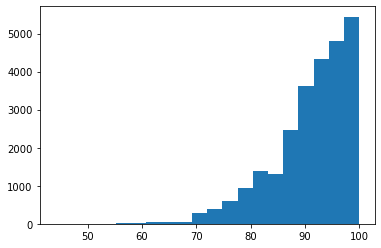

In [ ]:
plt.hist(df.Score,bins=20)

In [ ]:
df[df.Score < 70]['Restaurant Name'].value_counts()

OOB BC - Salsas Restaurant    4
Hunan Spicy                   4
La Superior Market            3
SV-Nala's                     3
JD's Market                   3
                             ..
La Michoacana                 1
99 Ranch Market #107          1
Park at the Domain, The       1
El Tacorrido                  1
Meches Mexican Restaurant     1
Name: Restaurant Name, Length: 150, dtype: int64

In [ ]:
df[df['Restaurant Name'].str.contains('Cabana')]

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description
64,Taco Cabana #129,78741.0,06/11/2021,89,"2507 E RIVERSIDE DR\nAUSTIN, TX 78741\n(30.234...",2800922,Routine Inspection
410,Taco Cabana Patio Rest #125,78750.0,06/16/2021,76,"13376 N US 183 HWY\nAUSTIN, TX 78750\n(30.4867...",2800474,Routine Inspection
502,Taco Cabana #128,78727.0,07/22/2020,92,"12525 N MOPAC EXPY\nAUSTIN, TX 78727\n(30.4209...",2800946,Routine Inspection
773,Taco Cabana #203,78758.0,11/04/2019,93,"8415 RESEARCH BLVD\nAUSTIN, TX 78758\n(30.3584...",2800517,Routine Inspection
1342,Taco Cabana #278,78749.0,11/19/2021,90,"6611 S MOPAC EXPY\nAUSTIN, TX 78749",2802942,Routine Inspection
...,...,...,...,...,...,...,...
25188,Taco Cabana #199,78748.0,07/29/2020,89,"9705 MANCHACA RD\nAUSTIN, TX 78748",2801240,Routine Inspection
25335,Taco Cabana #203,78758.0,03/03/2020,85,"8415 RESEARCH BLVD\nAUSTIN, TX 78758\n(30.3584...",2800517,Routine Inspection
25497,Taco Cabana #129,78741.0,03/27/2020,98,"2507 E RIVERSIDE DR\nAUSTIN, TX 78741\n(30.234...",2800922,Routine Inspection
25592,Taco Cabana #203,78758.0,11/30/2021,90,"8415 RESEARCH BLVD\nAUSTIN, TX 78758\n(30.3584...",2800517,Routine Inspection


In [ ]:
austin_rest = pd.read_csv(processed_data_directory + 'austin_restaurants.csv')

In [ ]:
len(df['Facility ID'].unique())

6680

In [ ]:
mean_scores = df.groupby(['Restaurant Name','Address']).mean().reset_index()[['Restaurant Name','Score']]